In [1]:
import sys
#### analysis
import pandas as pd
import glob #multiple readfiles
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import csv
import os
import re
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from collections import Counter
from string import printable
from wordcloud import WordCloud, STOPWORDS 
# !pip install missingno
import missingno as msno 
#### save temp to pickle object
import pickle 
import zipfile
import openpyxl
tqdm_notebook.pandas()
import string

C:\Users\Ghozy Haqqoni\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from ipykernel import kernelapp as app


In [3]:
def _readmultcsv(filepath):
    all_files = glob.glob(filepath + "/*.pkl")
    li = []
    for filename in tqdm_notebook(all_files):
        df = pd.read_pickle(filename)
        li.append(df)
    df = pd.concat(li, axis=0, ignore_index=True, sort=False)
    del li
    def _formatvar(df):
        df['timestamp'] = pd.to_datetime(df["timestamp"])
        df['sold'] = df['sold'].apply(lambda x: float(x))
        df['model_sold'] = df['model_sold'].apply(lambda x: float(x))
        df['hist_sold'] = df['hist_sold'].apply(lambda x: float(x))
        df['price'] = df['price'].progress_apply(lambda x: float(x))
        df.drop(['cat_id', 'cat_name' ,'sub_id', 'sub_name', 'sub_sub_id', 'sub_sub_name'], axis=1, inplace=True)
        return df
    return _formatvar(df)

s_mei = _readmultcsv(filepath = "C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\pickled\\latest_picks\\df_mei\\")
s_apr = _readmultcsv(filepath = "C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\pickled\\latest_picks\\df_april\\")

In [180]:
s_mei.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8858581 entries, 0 to 8858580
Data columns (total 14 columns):
item_id          float64
shop_id          float64
name             object
model_name       object
price            float64
location         object
sold             float64
model_sold       float64
hist_sold        float64
timestamp        datetime64[ns]
komoditas        object
weeks            int64
merge_cat        object
price_perunit    float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(5)
memory usage: 946.2+ MB


In [283]:
s_apr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7270032 entries, 0 to 7270031
Data columns (total 14 columns):
item_id          float64
shop_id          float64
name             object
model_name       object
price            float64
location         object
sold             float64
model_sold       float64
hist_sold        float64
timestamp        datetime64[ns]
komoditas        object
weeks            int64
merge_cat        object
price_perunit    float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(5)
memory usage: 776.5+ MB


In [ ]:
s_mei.komoditas.nunique() #584

In [ ]:
s_apr.komoditas.nunique() #481

In [ ]:
may = s_mei.komoditas.unique().tolist()
pril = s_apr.komoditas.unique().tolist()
list(set(may) - set(pril))

In [ ]:
s_mei.query('komoditas in ["tahu campur", "celana panjang bahan drill pria|celana panjang bahan pria",\
            "sari jeruk", "sandal kulit pria", "capcai", "kemeja pendek katun pria", "ikan benggol"]').shape

In [ ]:
s_mei = s_mei.query('komoditas not in ["tahu campur", "celana panjang bahan drill pria|celana panjang bahan pria",\
            "sari jeruk", "sandal kulit pria", "capcai", "kemeja pendek katun pria", "ikan benggol"]')
s_mei = s_mei.reset_index(drop=True)

In [ ]:
s_mei.komoditas.nunique() #584

In [ ]:
s_mei.shape

In [ ]:
s_mei.describe()

In [271]:
s_apr.describe()

,item_id,shop_id,price,sold,model_sold,hist_sold,weeks,price_perunit
count,7.270032e+06,7.270032e+06,7.270032e+06,7.270032e+06,6.141428e+06,7.270032e+06,7.270032e+06,7.270032e+06
mean,2.988382e+09,6.402990e+07,1.047335e+05,5.394988e+01,7.827280e+01,7.468984e+02,2.806086e+00,1.047335e+05
std,2.112972e+09,6.278912e+07,2.960965e+05,4.604693e+02,7.145056e+02,6.259488e+03,1.306754e+00,2.960965e+05
min,6.000000e+01,1.057000e+04,9.900000e+01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.900000e+01
25%,1.524575e+09,1.203856e+07,2.100000e+04,0.000000e+00,0.000000e+00,9.000000e+00,2.000000e+00,2.100000e+04
50%,2.406669e+09,3.746189e+07,5.440000e+04,4.000000e+00,3.000000e+00,4.900000e+01,3.000000e+00,5.440000e+04
75%,4.314966e+09,1.075019e+08,1.231820e+05,2.000000e+01,1.900000e+01,2.500000e+02,4.000000e+00,1.231820e+05
max,7.935850e+09,2.689599e+08,1.111000e+08,1.365060e+05,2.623330e+05,8.244640e+05,5.000000e+00,1.111000e+08


In [199]:
def _barcountdesc(df, title):
    f, ax = plt.subplots(figsize=(20,10))
    plt.suptitle(title, fontsize=15)
    df["komoditas"].value_counts().sort_values()[(len(df["komoditas"].value_counts())-10):].plot.bar(ax=ax)
    ax.set_ylabel('count', fontsize=14)
    plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//' + title + '.png')
    return

def _barcountdescW(df, title):
    f, ax = plt.subplots(figsize=(5,5))
    plt.suptitle(title, fontsize=15)
    df["weeks"].value_counts().sort_values().plot.bar(ax=ax)
    ax.set_ylabel('count', fontsize=14)
    plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//' + title + '.png')
    return

def _barcountdescL(df, title):
    f, ax = plt.subplots(figsize=(20,10))
    plt.suptitle(title, fontsize=15)
    df["location"].value_counts().sort_values()[(len(df["location"].value_counts())-10):].plot.bar(ax=ax)
    ax.set_ylabel('location', fontsize=14)
    plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//' + title + '.png')
    return

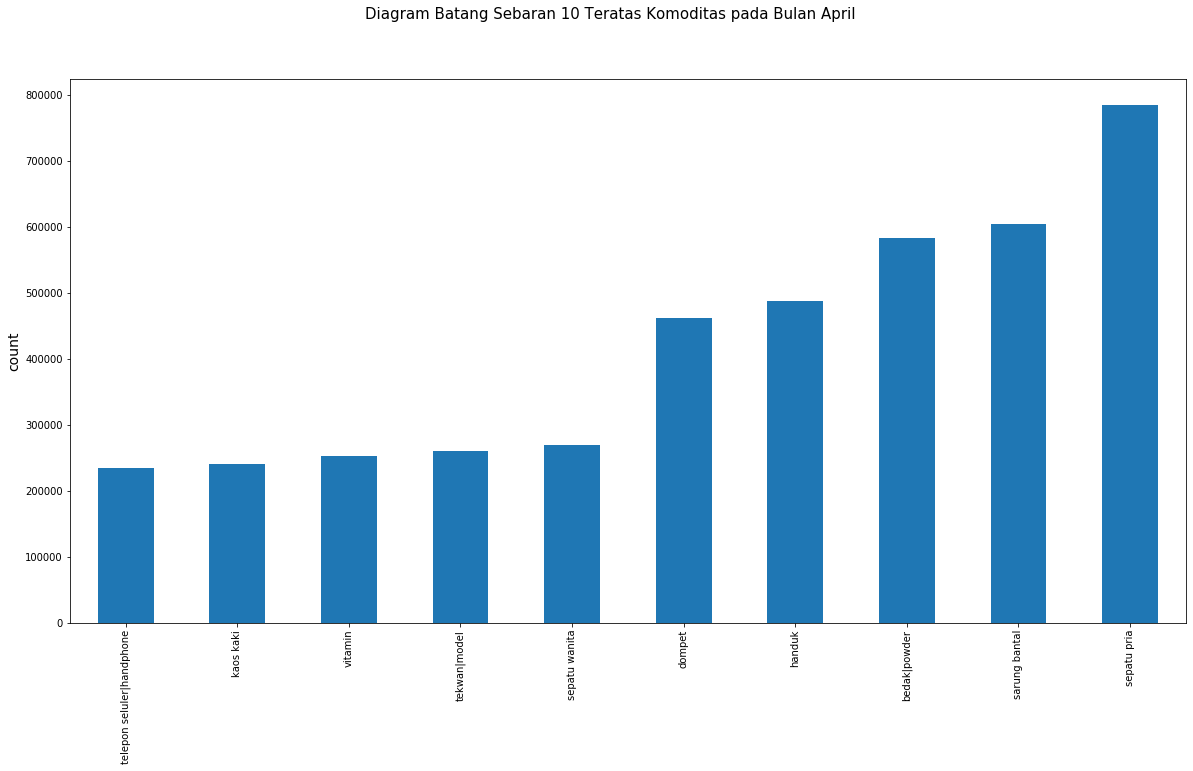

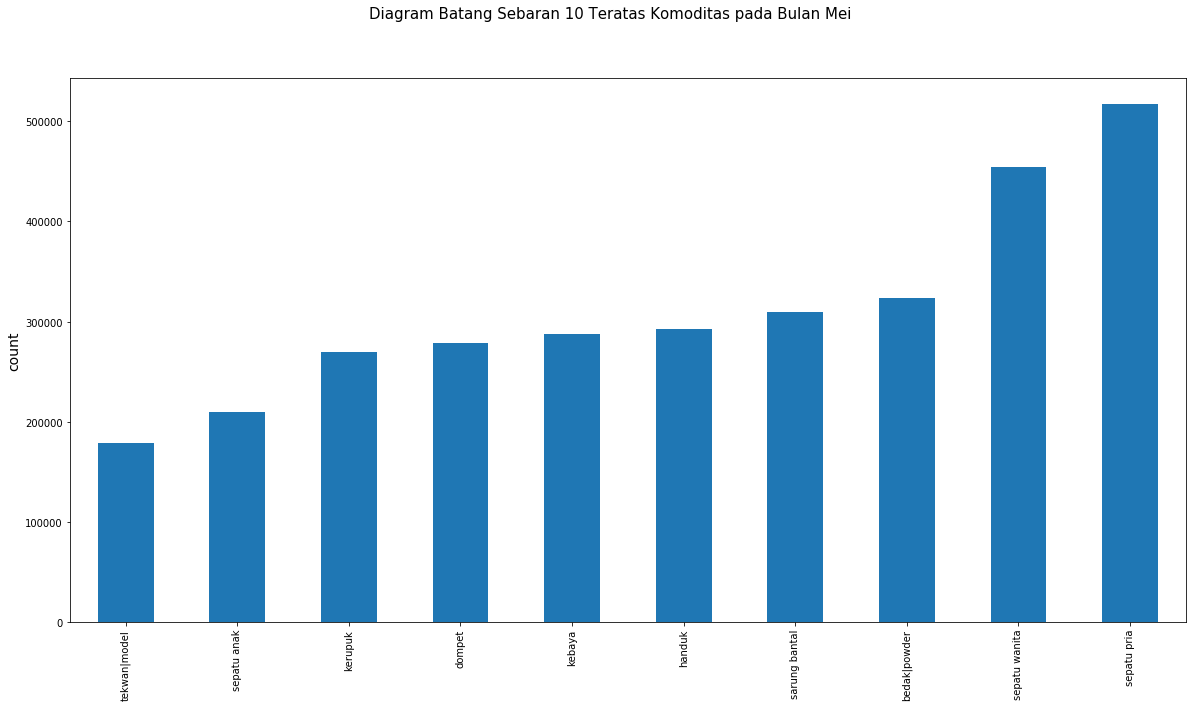

In [291]:
_barcountdesc(s_apr, title='Diagram Batang Sebaran 10 Teratas Komoditas pada Bulan April')
_barcountdesc(s_mei, title='Diagram Batang Sebaran 10 Teratas Komoditas pada Bulan Mei')

In [206]:
s_mei[s_mei.komoditas == 'telepon seluler|handphone'].price.sort_values(ascending=True).unique()

array([1.0000000e+02, 1.5000000e+02, 2.5000000e+02, ..., 8.0000000e+06,
       9.9000000e+06, 9.9999999e+07])

In [207]:
s_apr[s_apr.komoditas == 'telepon seluler|handphone'].price.sort_values(ascending=True).unique()

array([1.000e+02, 1.480e+02, 1.750e+02, ..., 7.575e+06, 1.000e+07,
       1.140e+07])

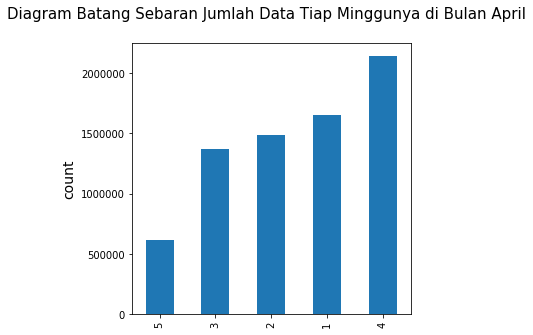

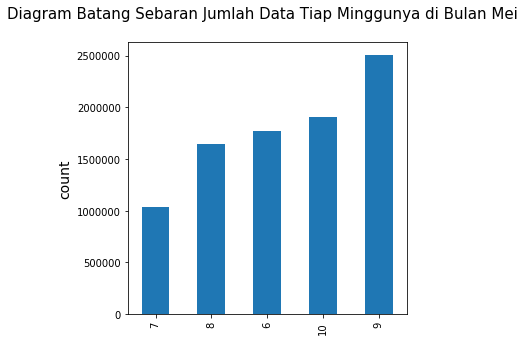

In [292]:
_barcountdescW(s_apr, title= 'Diagram Batang Sebaran Jumlah Data Tiap Minggunya di Bulan April')
_barcountdescW(s_mei, title= 'Diagram Batang Sebaran Jumlah Data Tiap Minggunya di Bulan Mei')

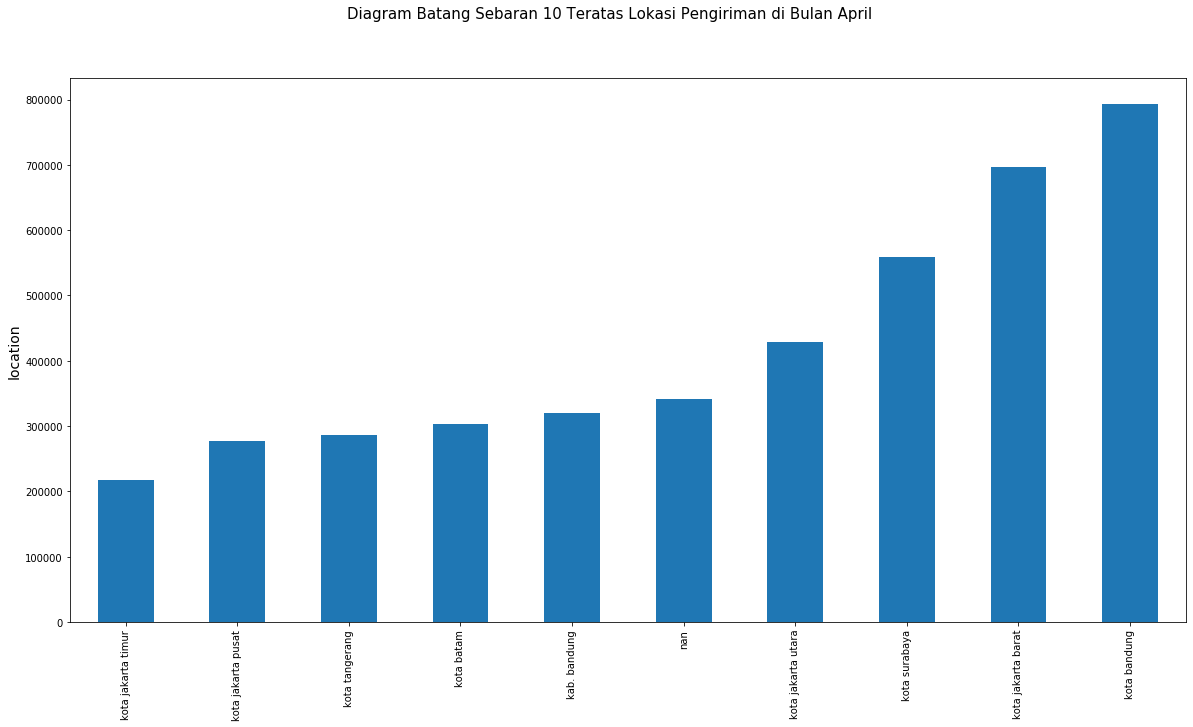

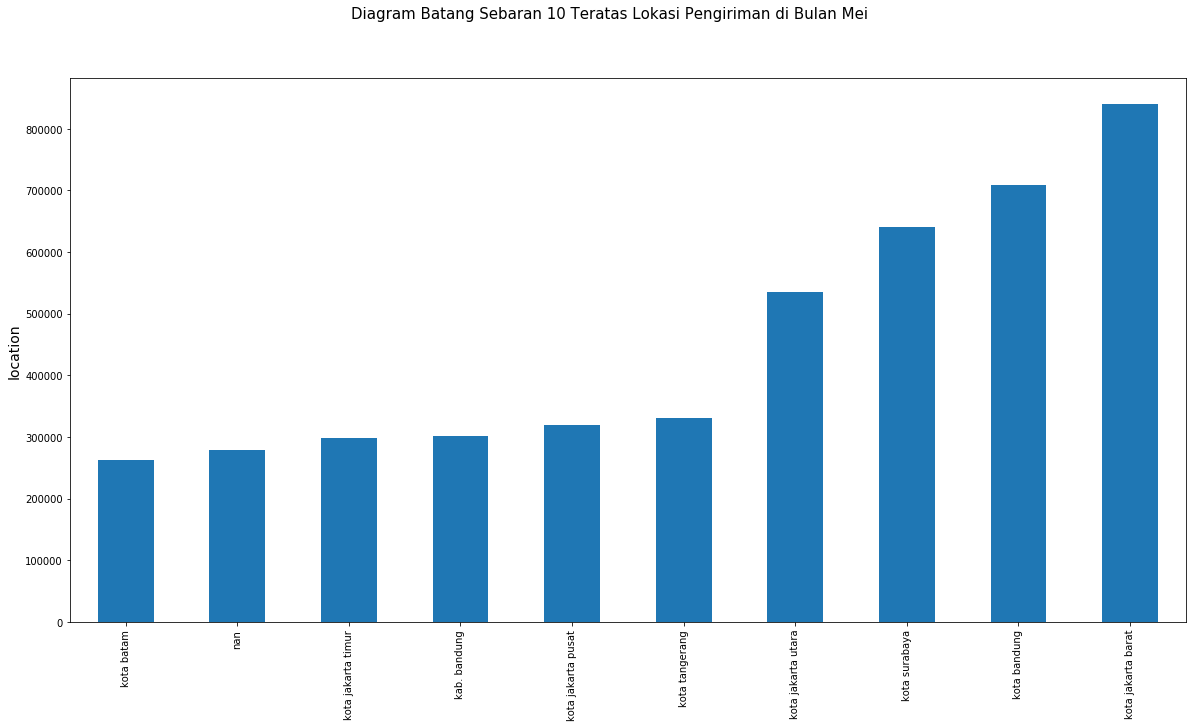

In [293]:
_barcountdescL(s_apr,title= 'Diagram Batang Sebaran 10 Teratas Lokasi Pengiriman di Bulan April')
_barcountdescL(s_mei,title= 'Diagram Batang Sebaran 10 Teratas Lokasi Pengiriman di Bulan Mei')

In [289]:
s_mei.to_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_mei_latest_final.pkl")
s_apr.to_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_apr_latest_final.pkl")

In [5]:
del s_apr
del s_mei

### Filter Kota IHK

In [6]:
df_apr = pd.read_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_apr_latest_final.pkl")
df_apr.shape

(7270032, 14)

In [7]:
df_mei = pd.read_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_mei_latest_final.pkl")
df_mei.shape

(8858519, 15)

In [15]:
df_apr['keterangan'] = np.nan
df_mei['keterangan'] = np.nan

In [308]:
# def _sampelin(df):
#     df = df.sample(frac=0.01, replace=True, random_state=777)
#     return df.reset_index(drop = True)

In [377]:
# sample_apr = _sampelin(df_apr)
# sample_mei = _sampelin(df_mei)

In [18]:
df_apr.location.unique()

array(['kota bandung', 'kota jakarta barat', 'kab. cianjur',
       'kota surabaya', 'kota surakarta (solo)', 'kab. banyuwangi',
       'kab. purworejo', 'kota bekasi', 'kab. bangka',
       'kab. bandung barat', 'kota jakarta timur', 'kab. boyolali',
       'kota jakarta utara', 'kab. madiun', 'kab. sidoarjo',
       'kota bandar lampung', 'kota banjarmasin', 'kota pangkal pinang',
       'kota denpasar', 'kab. sleman', 'kab. gresik', 'kota medan',
       'kota bogor', 'kota yogyakarta', 'kota tangerang',
       'kab. tulungagung', 'kab. tangerang', 'kota jakarta selatan',
       'kab. klaten', 'kota tangerang selatan', 'kab. bantul',
       'kota semarang', 'kab. bandung', 'kota palembang',
       'kota jakarta pusat', 'kota sukabumi', 'kab. wonosobo',
       'kota malang', 'kab. sukoharjo', 'kab. nganjuk', 'kota depok',
       'kota pontianak', 'kab. banyumas', 'kota kendari', 'kab. rembang',
       'kab. malang', 'kab. bekasi', 'kab. pati', 'kab. magelang',
       'kab. kota waring

## Fungsi
1. Kategori Target/Bukan
2. Kota IHK

In [19]:
def _pulaumana2(x):
    jawa = [
        'kota jakarta barat','kota jakarta timur','kota jakarta utara','kota jakarta selatan', 'kota jakarta pusat',
        'kota bogor', 'kota sukabumi','kota bandung','kota cirebon','kota bekasi','kota depok',
        'kota tasikmalaya','kab. cilacap','kab. purwokerto','kab. kudus','kota surakarta (solo)','kota semarang',
        'kota tegal','kota yogyakarta','kab. jember','kab. banyuwangi','kab. sumenep','kota kediri',
        'kota malang','kota probolinggo','kota madiun','kota surabaya','kota tangerang','kota cilegon', 'kota serang'
    ]
    condlist = [x in jawa]
    choicelist = ["Kota IHK di Pulau Jawa"]
    return np.select(condlist, choicelist, default='Bukan Kota IHK di Pulau Jawa')

def _kotaihk(df, path):  
    df = df[df['keterangan'] != "Bukan Kota IHK di Pulau Jawa"]
    df['kota_ihk']     = np.nan
    def _convertloc(df):
        with open (path + 'kota_ihk_jawa.csv') as file:
            kot = csv.reader(file, delimiter=',')
            kota = pd.DataFrame(kot, columns=['lokasi'])
            kota.lokasi = kota.lokasi.str.rstrip('\n')
            
            dfff = pd.DataFrame()
            for i in tqdm_notebook(kota.lokasi.values, desc='progressnya'):
                df2 = df[df['location'].str.contains(i, na=False, flags=re.IGNORECASE)]
                df2.loc[:,'kota_ihk'] = i
                dfff = dfff.append(df2)
            dfff.drop(['location'], axis=1,inplace = True)
            return dfff.reset_index(drop=True)
    return _convertloc(df)

In [20]:
df_apr.keterangan = df_apr.location.progress_apply(lambda x: _pulaumana2(x))
df_mei.keterangan = df_mei.location.progress_apply(lambda x: _pulaumana2(x))

In [21]:
df = pd.concat([df_apr, df_mei], axis=0, ignore_index=True, sort=False)

In [22]:
df.tail(3)

,item_id,shop_id,name,model_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,weeks,merge_cat,price_perunit,keterangan,kota_ihk
16128548,7.117556e+09,974536.0,keset / alas duduk motif tempe goreng fullprint,nan,39500.0,kota bandung,9.0,NaN,23.0,2020-05-31,tikar,10,perlengkapan rumah|dekorasi|tikar & karpet,39500.0,NaN,NaN
16128549,6.475600e+08,35078850.0,gabus tutup termos - 1 buah,nan,3000.0,kota tangerang,49.0,NaN,251.0,2020-05-31,teh,10,perlengkapan rumah|ruang makan|saringan teh & ...,3000.0,NaN,NaN
16128550,1.904690e+09,77892203.0,kualitas terbaik essen galatama babon ikan mas...,nan,42000.0,kota jakarta pusat,1.0,NaN,1.0,2020-05-31,bola,10,olahraga & outdoor|sepak bola & futsal|baju bola,42000.0,NaN,NaN


In [23]:
df.keterangan.value_counts()

Series([], Name: keterangan, dtype: int64)

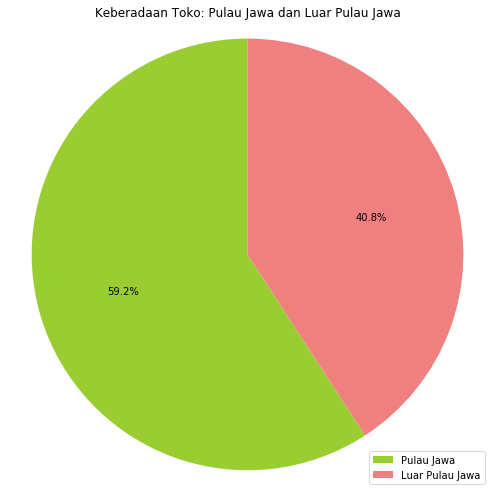

In [78]:
pp = pd.DataFrame(df.keterangan.value_counts())
###############
fig, ax = plt.subplots(figsize=(7,7))
colors = ['yellowgreen', 'lightcoral']
labels = ['Pulau Jawa', 'Luar Pulau Jawa']
plt.pie(pp['keterangan'], colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
ax.set_title("Keberadaan Toko: Pulau Jawa dan Luar Pulau Jawa")
plt.axis('equal')
plt.tight_layout()
plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//piechart_jawabukan.png')
plt.show()

In [24]:
samplee = df[df.keterangan != "Bukan Kota IHK di Pulau Jawa"]

In [25]:
samplee.tail(2)

,item_id,shop_id,name,model_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,weeks,merge_cat,price_perunit,keterangan,kota_ihk
16128549,6.475600e+08,35078850.0,gabus tutup termos - 1 buah,nan,3000.0,kota tangerang,49.0,NaN,251.0,2020-05-31,teh,10,perlengkapan rumah|ruang makan|saringan teh & ...,3000.0,NaN,NaN
16128550,1.904690e+09,77892203.0,kualitas terbaik essen galatama babon ikan mas...,nan,42000.0,kota jakarta pusat,1.0,NaN,1.0,2020-05-31,bola,10,olahraga & outdoor|sepak bola & futsal|baju bola,42000.0,NaN,NaN


In [26]:
def _kabkot(x):
    kab = [
        'kab. cilacap','kab. purwokerto','kab. kudus','kab. jember','kab. banyuwangi','kab. sumenep'
    ]
    condlist = [x in kab]
    choicelist = ["kabupaten"]
    return np.select(condlist, choicelist, default='kota')

samplee.kota_ihk = samplee.location.progress_apply(lambda x: _kabkot(x))

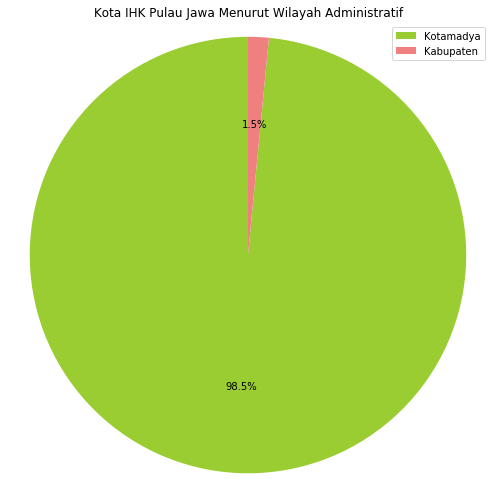

In [77]:
### 
pp = pd.DataFrame(samplee.kota_ihk.value_counts())
###############
fig, ax = plt.subplots(figsize=(7,7))
colors = ['yellowgreen', 'lightcoral']
labels = ['Kotamadya', 'Kabupaten']
plt.pie(pp['kota_ihk'], colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
ax.set_title("Kota IHK Pulau Jawa Menurut Wilayah Administratif")
plt.axis('equal') # equal ensures pie chart is drawn as a circle (equal aspect ratio)
plt.tight_layout()
plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//piechart_kabkot.png')
plt.show()

In [27]:
#luar jawa
sampley = df[df.keterangan == "Bukan Kota IHK di Pulau Jawa"]

In [28]:
def _luarjawaa(x):
    batm = [
        'kota batam'
    ]
    condlist = [x in batm]
    choicelist = ["batam"]
    return np.select(condlist, choicelist, default= 'Bukan Kota Batam')

sampley.kota_ihk = sampley.location.progress_apply(lambda x: _luarjawaa(x))

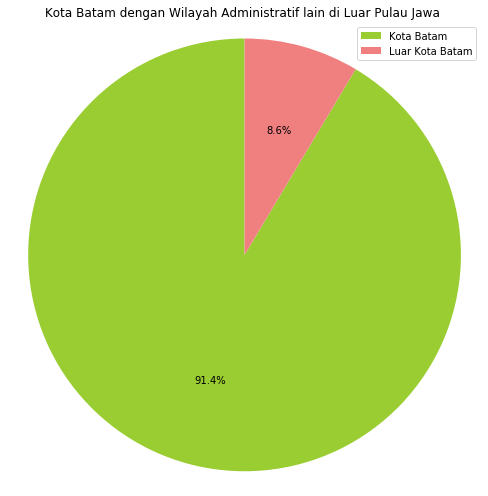

In [76]:
### 
pp = pd.DataFrame(sampley.kota_ihk.value_counts())
###############
fig, ax = plt.subplots(figsize=(7,7))
colors = ['yellowgreen', 'lightcoral']
labels = ['Kota Batam', 'Luar Kota Batam']
plt.pie(pp['kota_ihk'], colors=colors, startangle=90, autopct='%1.1f%%')
plt.legend(labels, loc="best")
ax.set_title("Kota Batam dengan Wilayah Administratif lain di Luar Pulau Jawa ")
plt.axis('equal') # equal ensures pie chart is drawn as a circle (equal aspect ratio)
plt.tight_layout()
plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//piechart_batambukan.png')
plt.show()

In [29]:
samplee.komoditas.unique()

array(['abon', 'cabe merah|cabe merah kering|cabai merah kering',
       'sabun detergen bubuk|detergen bubuk',
       'labu parang|labu manis|labu merah',
       'setelan rok dan blus|terusan', 'buah melinjo|melinjo mentah',
       'celana panjang jeans wanita', 'celana panjang jeans anak',
       'celana panjang jeans pria', 'celana panjang katun pria',
       'kemeja panjang batik pria', 'pengharum cucian|pelembut',
       'personal komputer|desktop', 'kaos kutang|singlet pria',
       'kemeja pendek batik pria', 'pembasmi nyamuk elektrik',
       'printer|printer desk jet', 'pakaian olahraga wanita',
       'baju kaos|t-shirt anak', 'baju kaos|t-shirt pria',
       'bumbu masak jadi|bumbu', 'cabe hijau|cabai hijau',
       'cabe rawit|cabai rawit', 'sabun cair|cuci piring|pencuci piring',
       'sepatu olahraga wanita', 'seragam sekolah wanita',
       'ketupat|lontong sayur', 'pakaian olahraga pria',
       'ikan panggang|mangut', 'kemeja pendek wanita',
       'makanan ringan|sn

In [133]:
pangan = ['beras', 'cabe rawit|cabai rawit', 'gula pasir', 'minyak goreng']
bubu = samplee[samplee['komoditas'].isin(pangan)]
bubu = samplee[samplee['komoditas'] == 'beras']
# bubu = samplee[samplee['komoditas'] == 'minyak goreng']

In [134]:
bubu = bubu.reset_index(drop=True)
bubu = bubu[bubu.model_name != "nan"]
bubu = bubu.reset_index(drop=True)
bubu.price_perunit.sort_values(ascending=False)

3633     3500000.0
14267    3500000.0
19111    3500000.0
16856    3500000.0
9128     3500000.0
           ...    
13566        700.0
20841        700.0
20842        700.0
4424         700.0
12282        700.0
Name: price_perunit, Length: 27768, dtype: float64

In [139]:
bubu.shape

(27768, 16)

In [149]:
#manual mapping
searchfor = ['basmati', 'pulen', 'super', 'organi', 'shirataki', 'premium', ' kacang', 'cap', 'hijau',
             'tempat', 'kencur', 'jepang', 'garudafood', 'rantai', 'beras merah', 'premium', 'kunyit',
             'rojo', 'lumbung', 'sirup', 'plastik', 'infaq', 'zakat', 'beras', 'pandan', 'bmw', 'ramos',
             'spesial', 'japan', 'kebuli', 'karung', 'broken', 'tambah', 'plastik', 'hitam' , 'topi', 'biru',
            'pink', 'paket', 'white', 'blue', 'rose', 'tropical', 'kunci', 'sania', 'original', 'gulaku',
            'bimoli','sunco' 'filma', 'sovia', 'fortune', 'jeruk', 'jeruk garut']
searchfor2 = ['plastik', 'hitam' , 'topi', 'biru','pink', 'paket', 'white', 'blue', 'wadah', 'tepung']

bubu = bubu[~bubu.model_name.str.contains('|'.join(searchfor))]
bubu = bubu[~bubu.name.str.contains('|'.join(searchfor2))]
 
# bubu.model_name = bubu.model_name.str.replace('[^0-9]','')

In [150]:
bubu.tail()

,item_id,shop_id,name,model_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,weeks,merge_cat,price_perunit,keterangan,kota_ihk
27718,4.815433e+09,73585876.0,tiwul instan /oyek /gatot /beras jagung,tiwul putih /kuning,10000.0,kab. trenggalek,4.0,1.0,4.0,2020-05-31,beras,10,makanan & minuman|makanan instan|makanan insta...,10000.0,NaN,kota
27720,4.815433e+09,73585876.0,tiwul instan /oyek /gatot /beras jagung,gatot 200 gram,18000.0,kab. trenggalek,4.0,0.0,4.0,2020-05-31,beras,10,makanan & minuman|makanan instan|makanan insta...,18000.0,NaN,kota
27721,4.815433e+09,73585876.0,tiwul instan /oyek /gatot /beras jagung,gatot 500 gram,10000.0,kab. trenggalek,4.0,2.0,4.0,2020-05-31,beras,10,makanan & minuman|makanan instan|makanan insta...,10000.0,NaN,kota
27756,1.363903e+09,1700714.0,bihun beras segitiga bintang kepingan eceran,4 keping,10000.0,kota jakarta barat,12.0,23.0,35.0,2020-05-31,beras,10,makanan & minuman|bahan pokok|mie kering,10000.0,NaN,kota
27757,1.363903e+09,1700714.0,bihun beras segitiga bintang kepingan eceran,2 keping,6000.0,kota jakarta barat,12.0,12.0,35.0,2020-05-31,beras,10,makanan & minuman|bahan pokok|mie kering,6000.0,NaN,kota


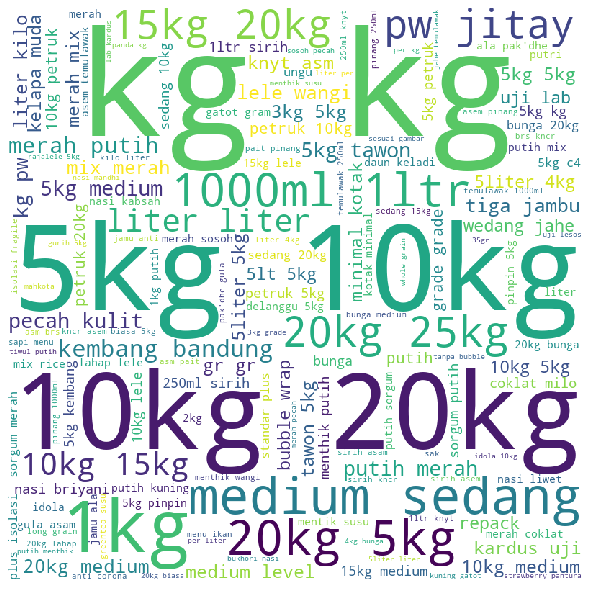

In [152]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in bubu.model_name: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//wordcloud_pangan_beras.png')
plt.show() 


In [51]:
samplee.komoditas.unique()

array(['abon', 'cabe merah|cabe merah kering|cabai merah kering',
       'sabun detergen bubuk|detergen bubuk',
       'labu parang|labu manis|labu merah',
       'setelan rok dan blus|terusan', 'buah melinjo|melinjo mentah',
       'celana panjang jeans wanita', 'celana panjang jeans anak',
       'celana panjang jeans pria', 'celana panjang katun pria',
       'kemeja panjang batik pria', 'pengharum cucian|pelembut',
       'kaos kutang|singlet pria', 'kemeja pendek batik pria',
       'pembasmi nyamuk elektrik', 'printer|printer desk jet',
       'pakaian olahraga wanita', 'baju kaos|t-shirt pria',
       'bumbu masak jadi|bumbu', 'cabe hijau|cabai hijau',
       'cabe rawit|cabai rawit', 'sabun cair|cuci piring|pencuci piring',
       'sepatu olahraga wanita', 'ketupat|lontong sayur',
       'ikan panggang|mangut', 'kemeja pendek wanita',
       'makanan ringan|snack', 'sepatu olahraga anak',
       'sepatu olahraga pria', 'seragam sekolah anak',
       'batu bata|batu tela', 'buku

In [153]:
sandang = ['celana panjang jeans pria', 'celana dalam pria', 'kemeja pendek anak']

In [154]:
bibi = samplee[samplee['komoditas'].isin(sandang)]
bibi = bibi.reset_index(drop=True)
bibi = bibi[bibi.model_name != "nan"]
bibi = bibi.reset_index(drop=True)
bibi.price_perunit.sort_values(ascending=False)

1136     490000.0
7683     490000.0
7649     490000.0
7650     490000.0
7651     490000.0
           ...   
43553      2999.0
31476      2999.0
25489      2999.0
12517      2999.0
26481      2000.0
Name: price_perunit, Length: 44107, dtype: float64

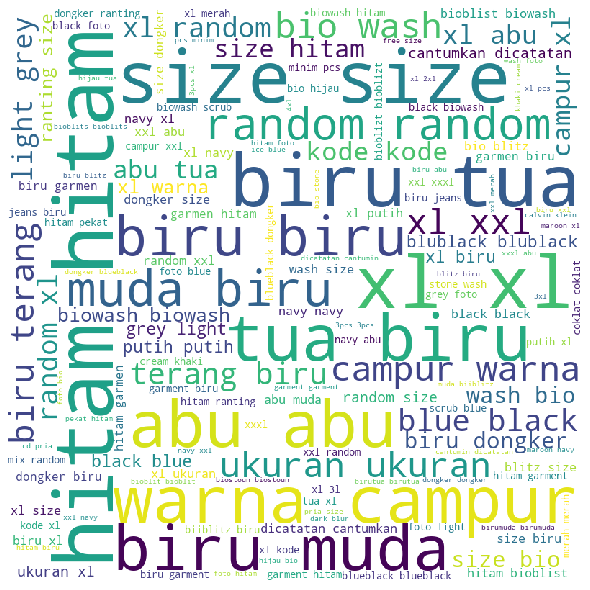

In [68]:
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import pandas as pd 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in bibi.model_name: 
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split() 
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.savefig('C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_8_DS//Training//Scraping//shopees//output//akhir//wordcloud_sandang.png')
plt.show() 


In [ ]:
# ##biar ga memory error
# df_apr = df_apr[df_apr.keterangan != "Bukan Kota IHK di Pulau Jawa"]
# df_mei = df_mei[df_mei.keterangan != "Bukan Kota IHK di Pulau Jawa"]

In [ ]:
apr = _kotaihk(df_apr, path = r'C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_7_DS//Skripsi//fix//penulisan//bantuan//BPS//')

In [450]:
mei = _kotaihk(df_mei, path = r'C://Users//Ghozy Haqqoni//Documents//!Kuliah//Semester_7_DS//Skripsi//fix//penulisan//bantuan//BPS//')

C:\Users\Ghozy Haqqoni\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [451]:
mei.kota_ihk.nunique()

25

In [452]:
mei.shape

(6535572, 15)

In [454]:
apr.shape

(5418600, 15)

In [456]:
del df_apr
del df_mei
del df

In [458]:
#nanti ini run dicolab
apr.to_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_apr_ihk.pkl")
mei.to_pickle("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\df_mei_ihk.pkl")
#pasca read, lakukan ini
# df_apr = apr[apr.keterangan != "Bukan Kota IHK di Pulau Jawa"]
# df_mei = mei[mei.keterangan != "Bukan Kota IHK di Pulau Jawa"]
##baru nanti concat, trus jalanin fungsi _kotaihk()

# CORETAN

In [29]:
def outlier_treatment(df):
    sorted(df['price'])
    Q1 = df['price'].quantile(0.25)
    Q3 = df['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_range = Q1 - (1.5 * IQR)
    upper_range = Q3 + (1.5 * IQR)
    return IQR, lower_range, upper_range

outlier_treatment(s)

(98096.0, -127144.0, 265240.0)

In [11]:
s_mei.describe()

,item_id,shop_id,price,sold,model_sold,hist_sold
count,1.924339e+07,1.924339e+07,1.924339e+07,1.924339e+07,1.377943e+07,1.924339e+07
mean,4.333700e+09,1.120674e+08,1.816684e+05,3.036135e+01,4.060372e+01,3.390892e+02
std,2.351341e+09,7.587649e+07,1.386682e+06,3.607917e+02,7.348571e+02,4.956488e+03
min,1.200000e+01,1.057000e+04,1.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.260362e+09,3.467920e+07,2.700000e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.325949e+09,1.212946e+08,7.500000e+04,0.000000e+00,0.000000e+00,1.000000e+00
75%,6.533378e+09,1.784624e+08,1.790000e+05,4.000000e+00,4.000000e+00,4.500000e+01
max,6.541639e+10,2.676791e+08,1.000000e+09,8.982600e+04,4.308960e+05,9.361200e+05


In [33]:
s.hist_sold.min()

1.0

In [398]:
outlier_treatment(s_apr)

(121300.0, -160050.0, 325150.0)

In [397]:
s_apr.describe()

,item_id,shop_id,price,sold,model_sold,hist_sold
count,6.713782e+06,6.713782e+06,6.713782e+06,6.713782e+06,5.836874e+06,6.713782e+06
mean,3.687560e+09,9.383878e+07,1.294578e+05,3.576856e+01,5.806998e+01,5.463231e+02
std,2.353954e+09,6.975243e+07,5.890512e+05,4.370852e+02,5.932998e+02,5.404766e+03
min,1.035850e+05,1.057000e+04,9.900000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.901974e+09,2.453726e+07,2.190000e+04,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.773448e+09,8.658900e+07,5.500000e+04,0.000000e+00,0.000000e+00,8.000000e+00
75%,5.916594e+09,1.625476e+08,1.432000e+05,7.000000e+00,9.000000e+00,1.060000e+02
max,7.934529e+09,2.627344e+08,8.000000e+08,1.365060e+05,2.623330e+05,8.244640e+05


In [12]:
fraud_price_mei = s_mei[s_mei['price'] >= 9999999.0]
fraud_price_mei.komoditas.nunique()

203

In [13]:
fraud_price_mei.komoditas.unique()

array(['vcd|dvd|dvd player|vcd player', 'printer|printer desk jet',
       'bumbu masak jadi|bumbu', 'cd|rec |radio', 'ice cream|es krim',
       'lemari hias|bupet', 'kulkas|lemari es', 'meja kursi makan',
       'air conditioner', 'kopi bubuk|kopi', 'laptop|notebook',
       'sepatu wanita', 'baterai|batu bateray', 'es batu| es',
       'meja belajar', 'mie', 'sepeda motor', 'susu kedelai',
       'tekwan|model', 'tempat tidur', 'lemari hias', 'mainan anak',
       'mesin jahit', 'jam tangan', 'mesin cuci', 'roti tawar',
       'mie basah', 'selai', 'televisi', 'blender', 'gen set|genset',
       'kentang|kentang rendang', 'keramik', 'knalpot', 'setrika',
       'speaker', 'vitamin', 'kamera', 'pempek', 'sepeda', 'bakso',
       'bedak|powder', 'donat', 'jamur', 'kursi', 'lilin', 'mixer',
       'panci', 'papan', 'raket', 'salak', 'semen', 'tempe', 'tas',
       'helm', 'jamu', 'oven', 'pare', 'sate',
       'personal komputer|desktop', 'kompor', 'lemari pakaian',
       'kacamata', 

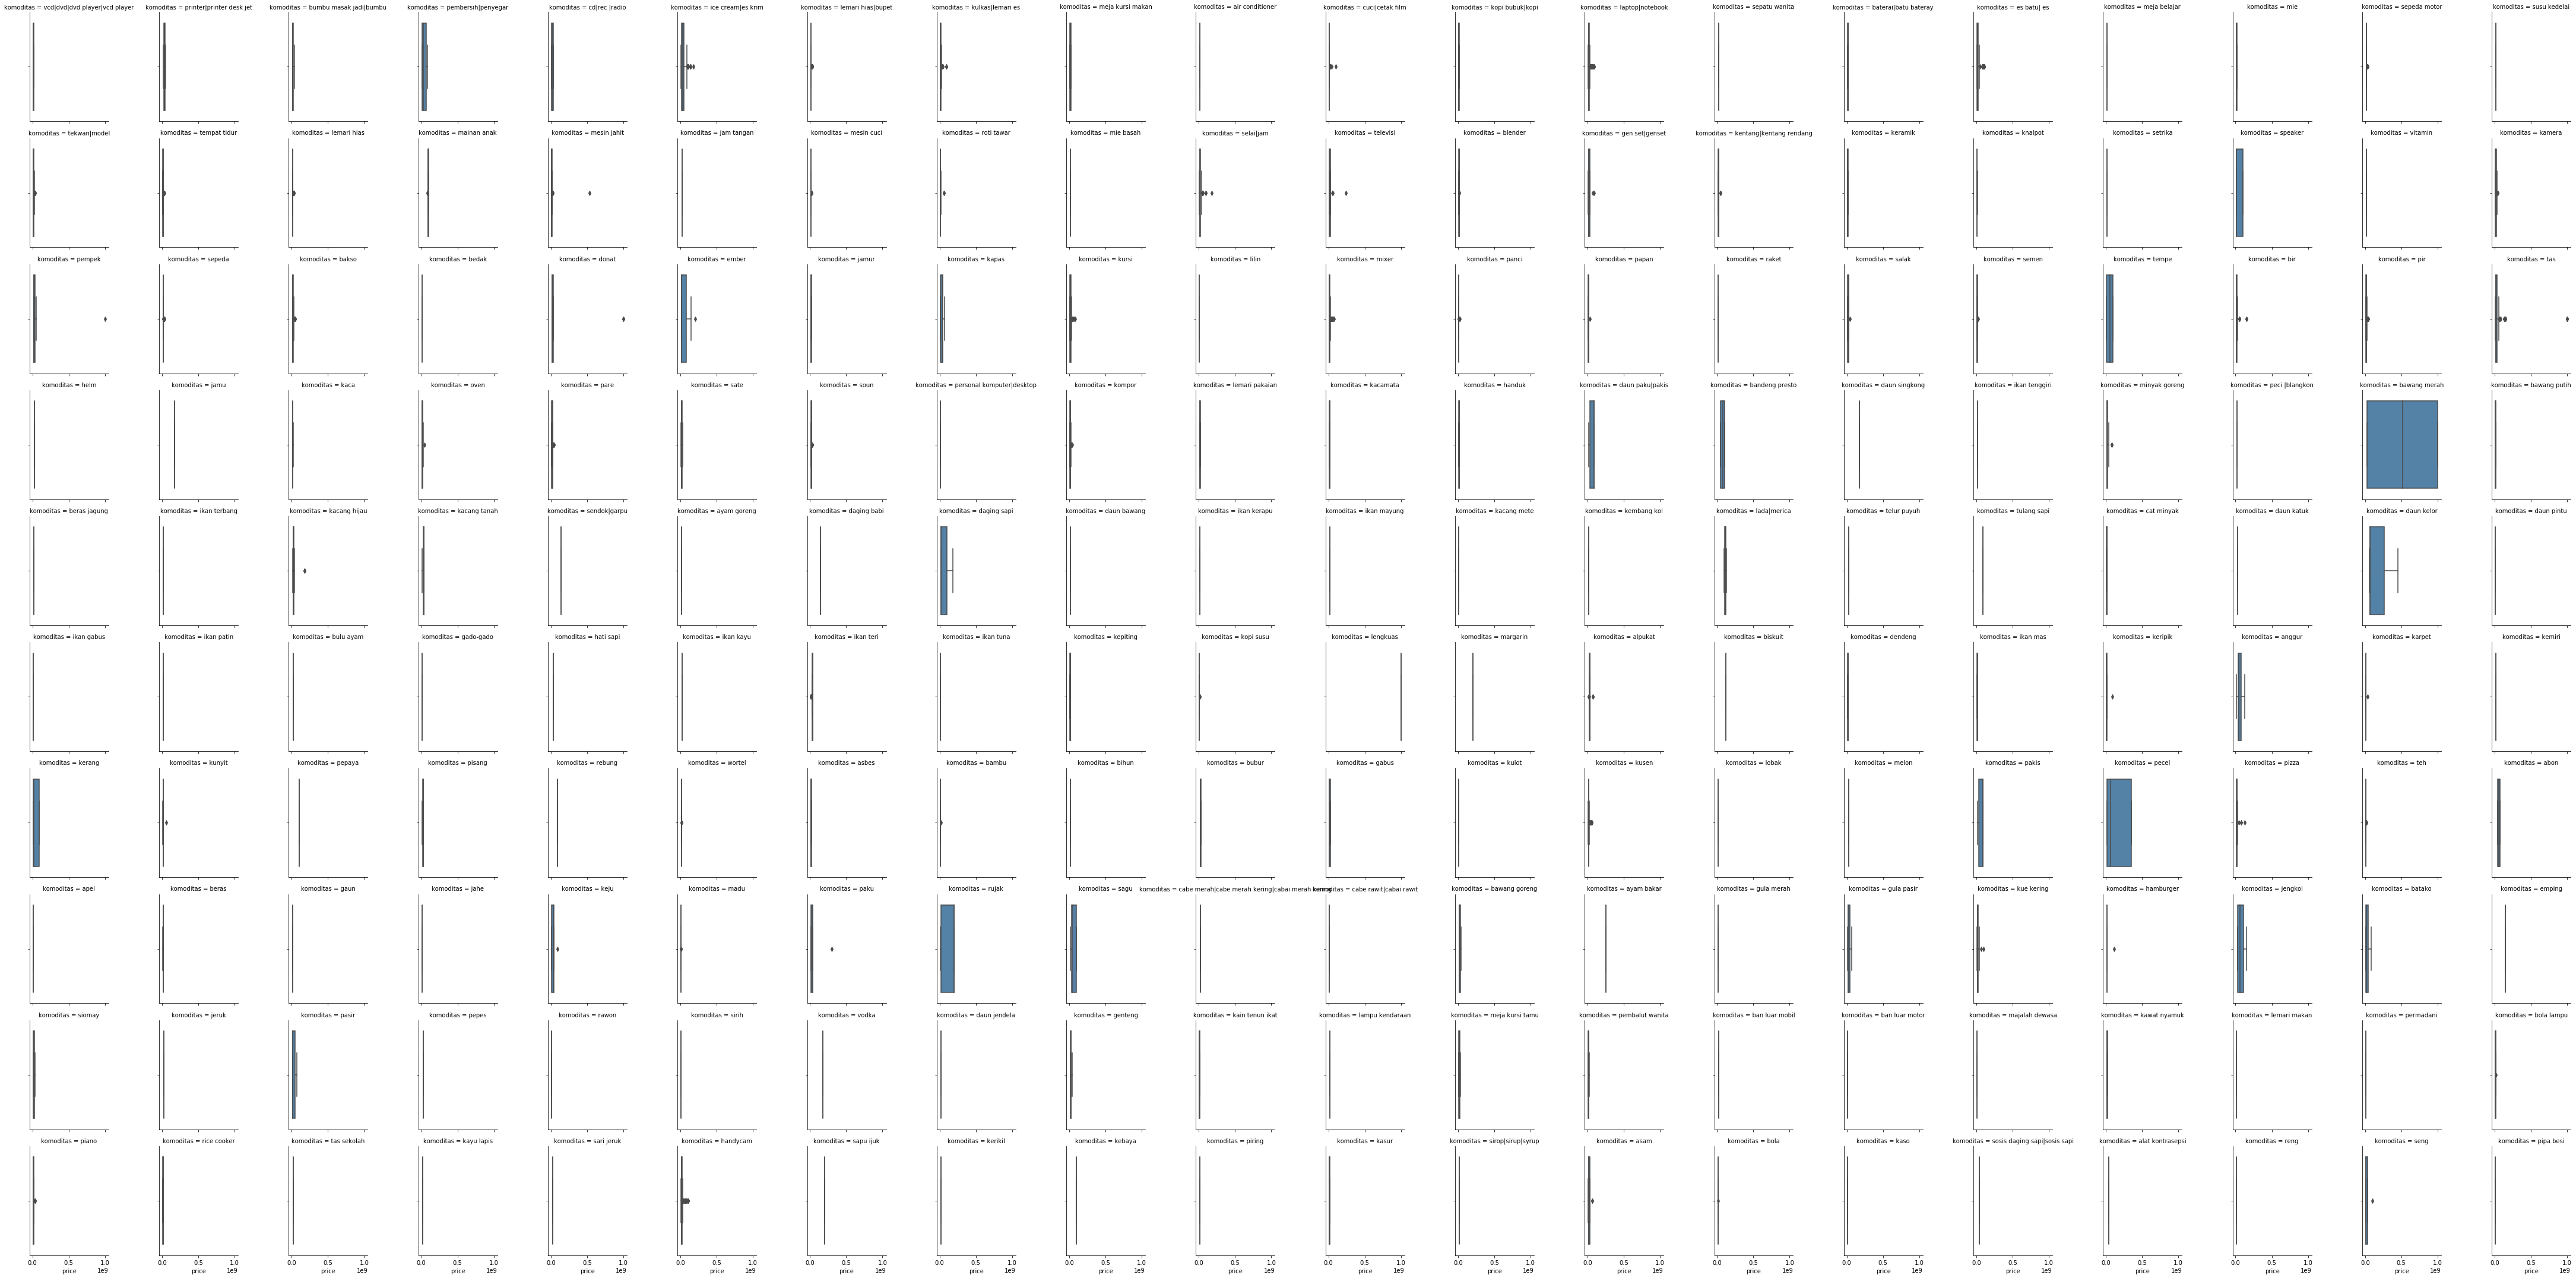

In [61]:
# 
# h = sns.FacetGrid(fraud_price_mei, col="komoditas", margin_titles=True, col_wrap=20)
# sns_plot = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
# sns_plot.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\fraud_price_mei.png")

In [14]:
fraud_price_mei_b = s_mei[s_mei['price'] <= 999]
fraud_price_mei_b.komoditas.nunique()

277

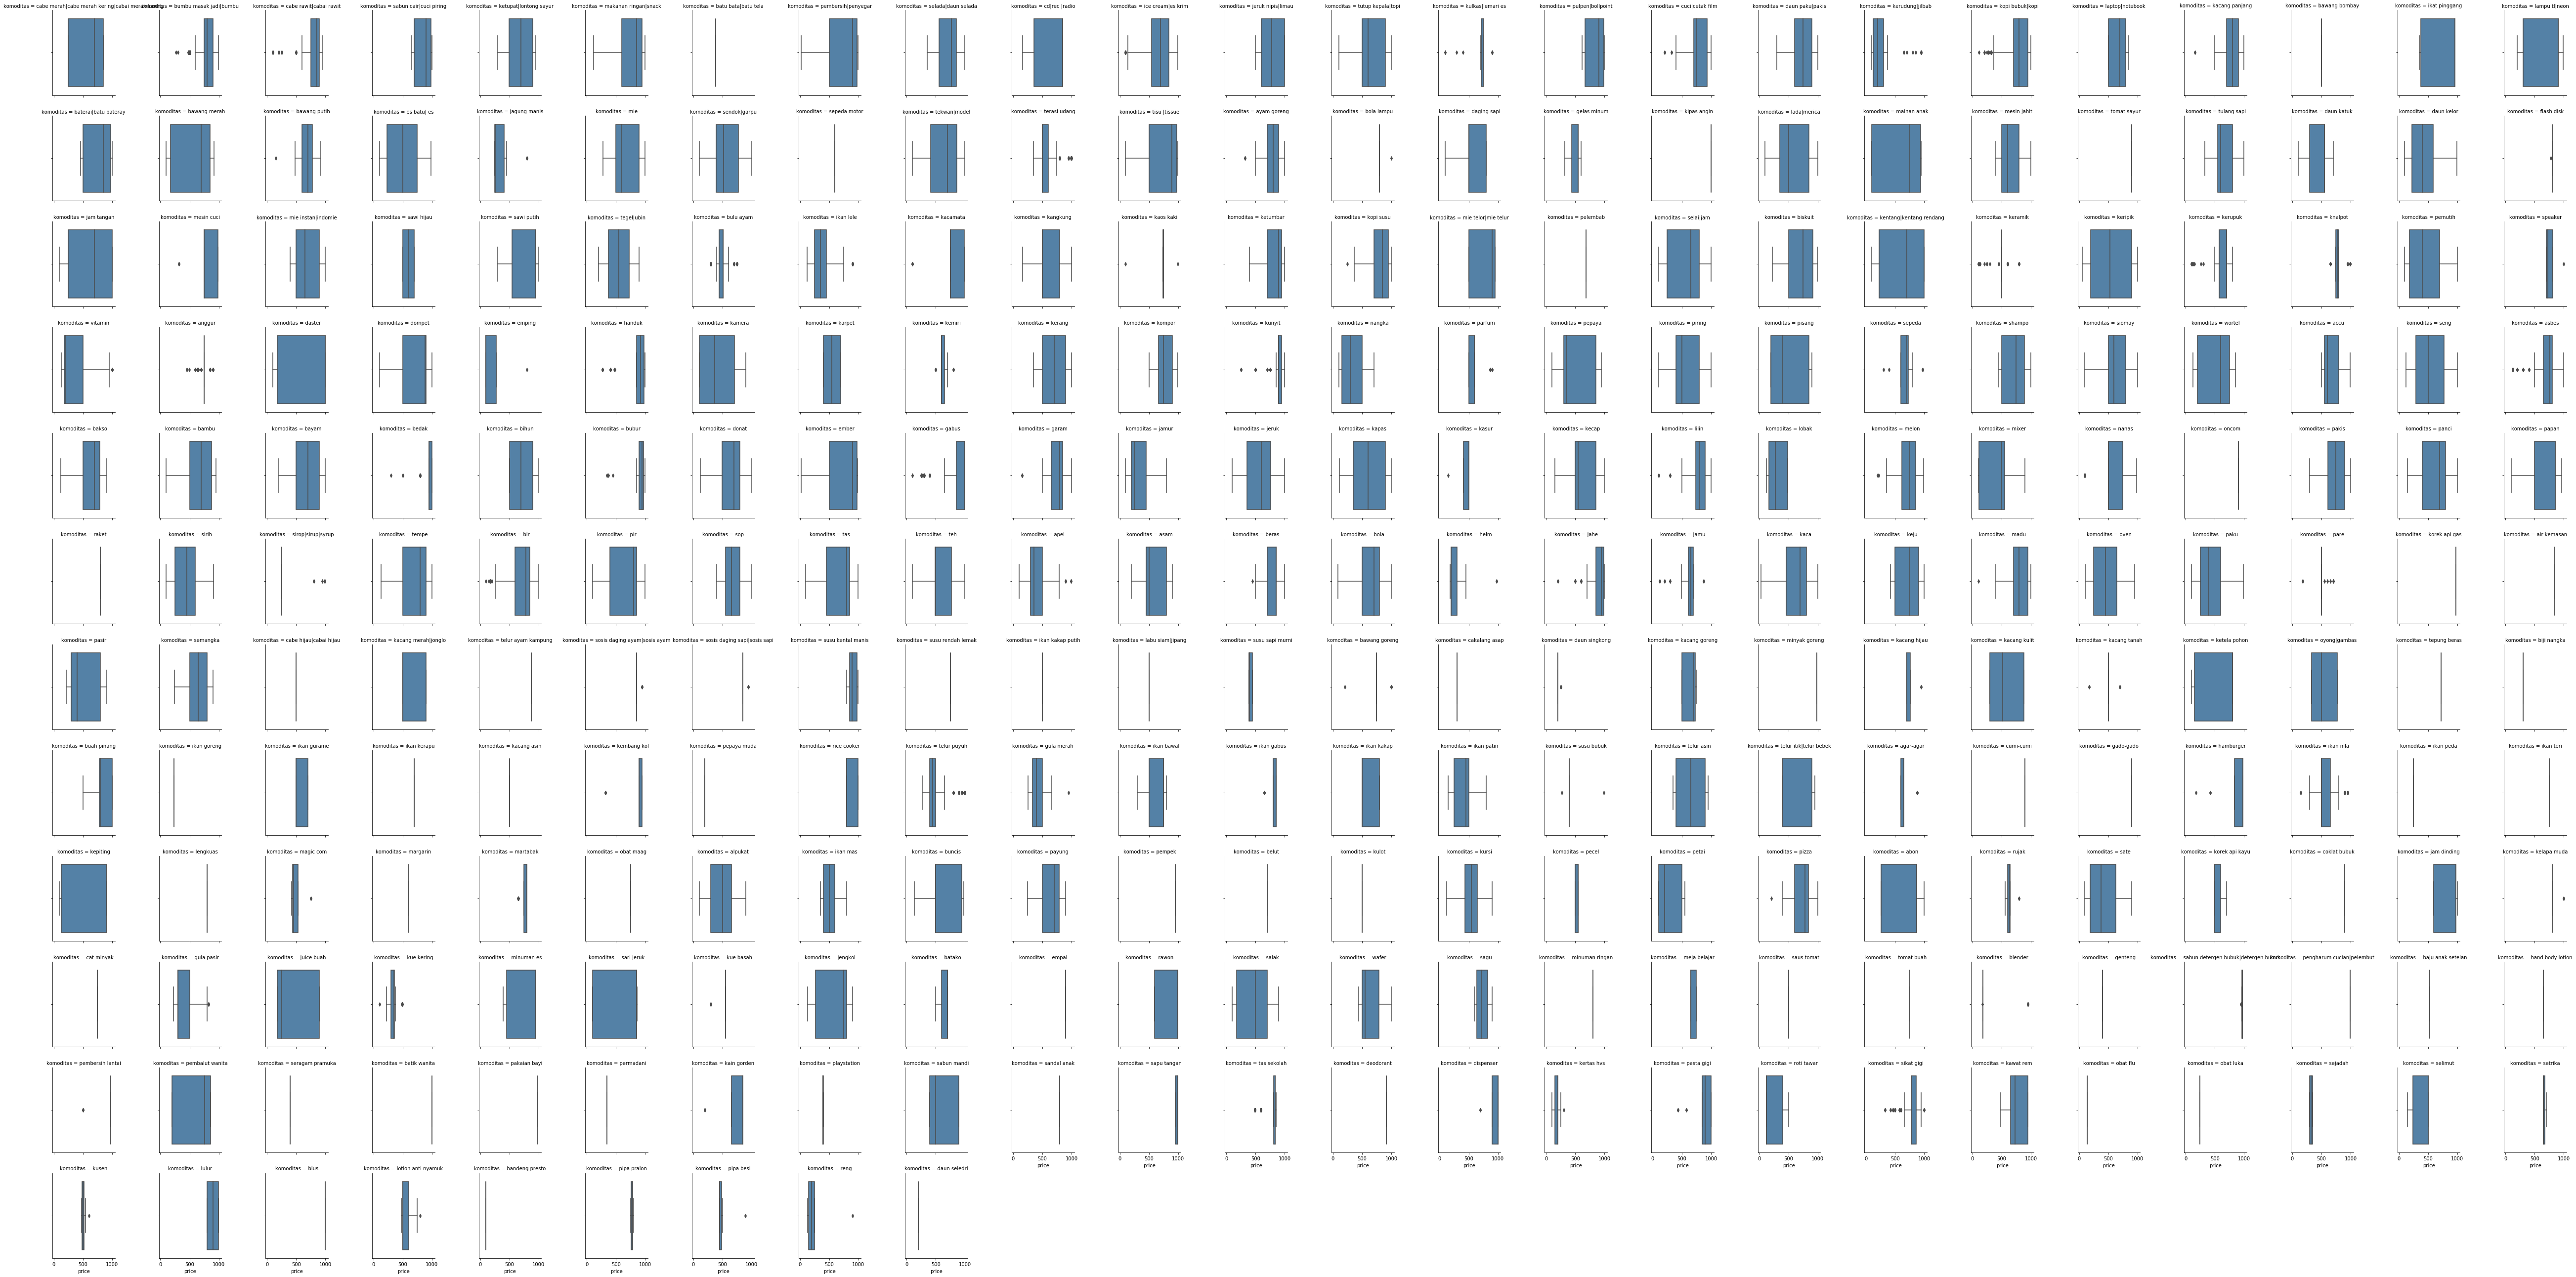

In [25]:
h = sns.FacetGrid(fraud_price_mei_b, col="komoditas", margin_titles=True, col_wrap=24)
sns_plot = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
sns_plot.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\fraud_price_mei_b.png")

In [399]:
fraud_price_apr = s_apr[s_apr['price'] >= 9999999.0]
fraud_price_apr.komoditas.nunique()

67

In [400]:
fraud_price_apr[fraud_price_apr["komoditas"] == "payung"]

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas
148330,6.604975e+09,189147636.0,Toko-Kerajinan-Tangan- Payung Geulis /Ukuran S...,NaN,24721,Payung Hias,24108000.0,KOTA JAKARTA PUSAT,0.0,NaN,0.0,2020-04-03,payung
150399,4.315279e+09,213001432.0,Payung Geulis Payung Dekorasi,NaN,24721,Payung Hias,38500000.0,KOTA TASIKMALAYA,0.0,NaN,0.0,2020-04-03,payung
6385554,6.604975e+09,189147636.0,Toko-Kerajinan-Tangan- Payung Geulis /Ukuran S...,NaN,24721,Payung Hias,24108000.0,KOTA JAKARTA PUSAT,0.0,NaN,0.0,2020-04-28,payung


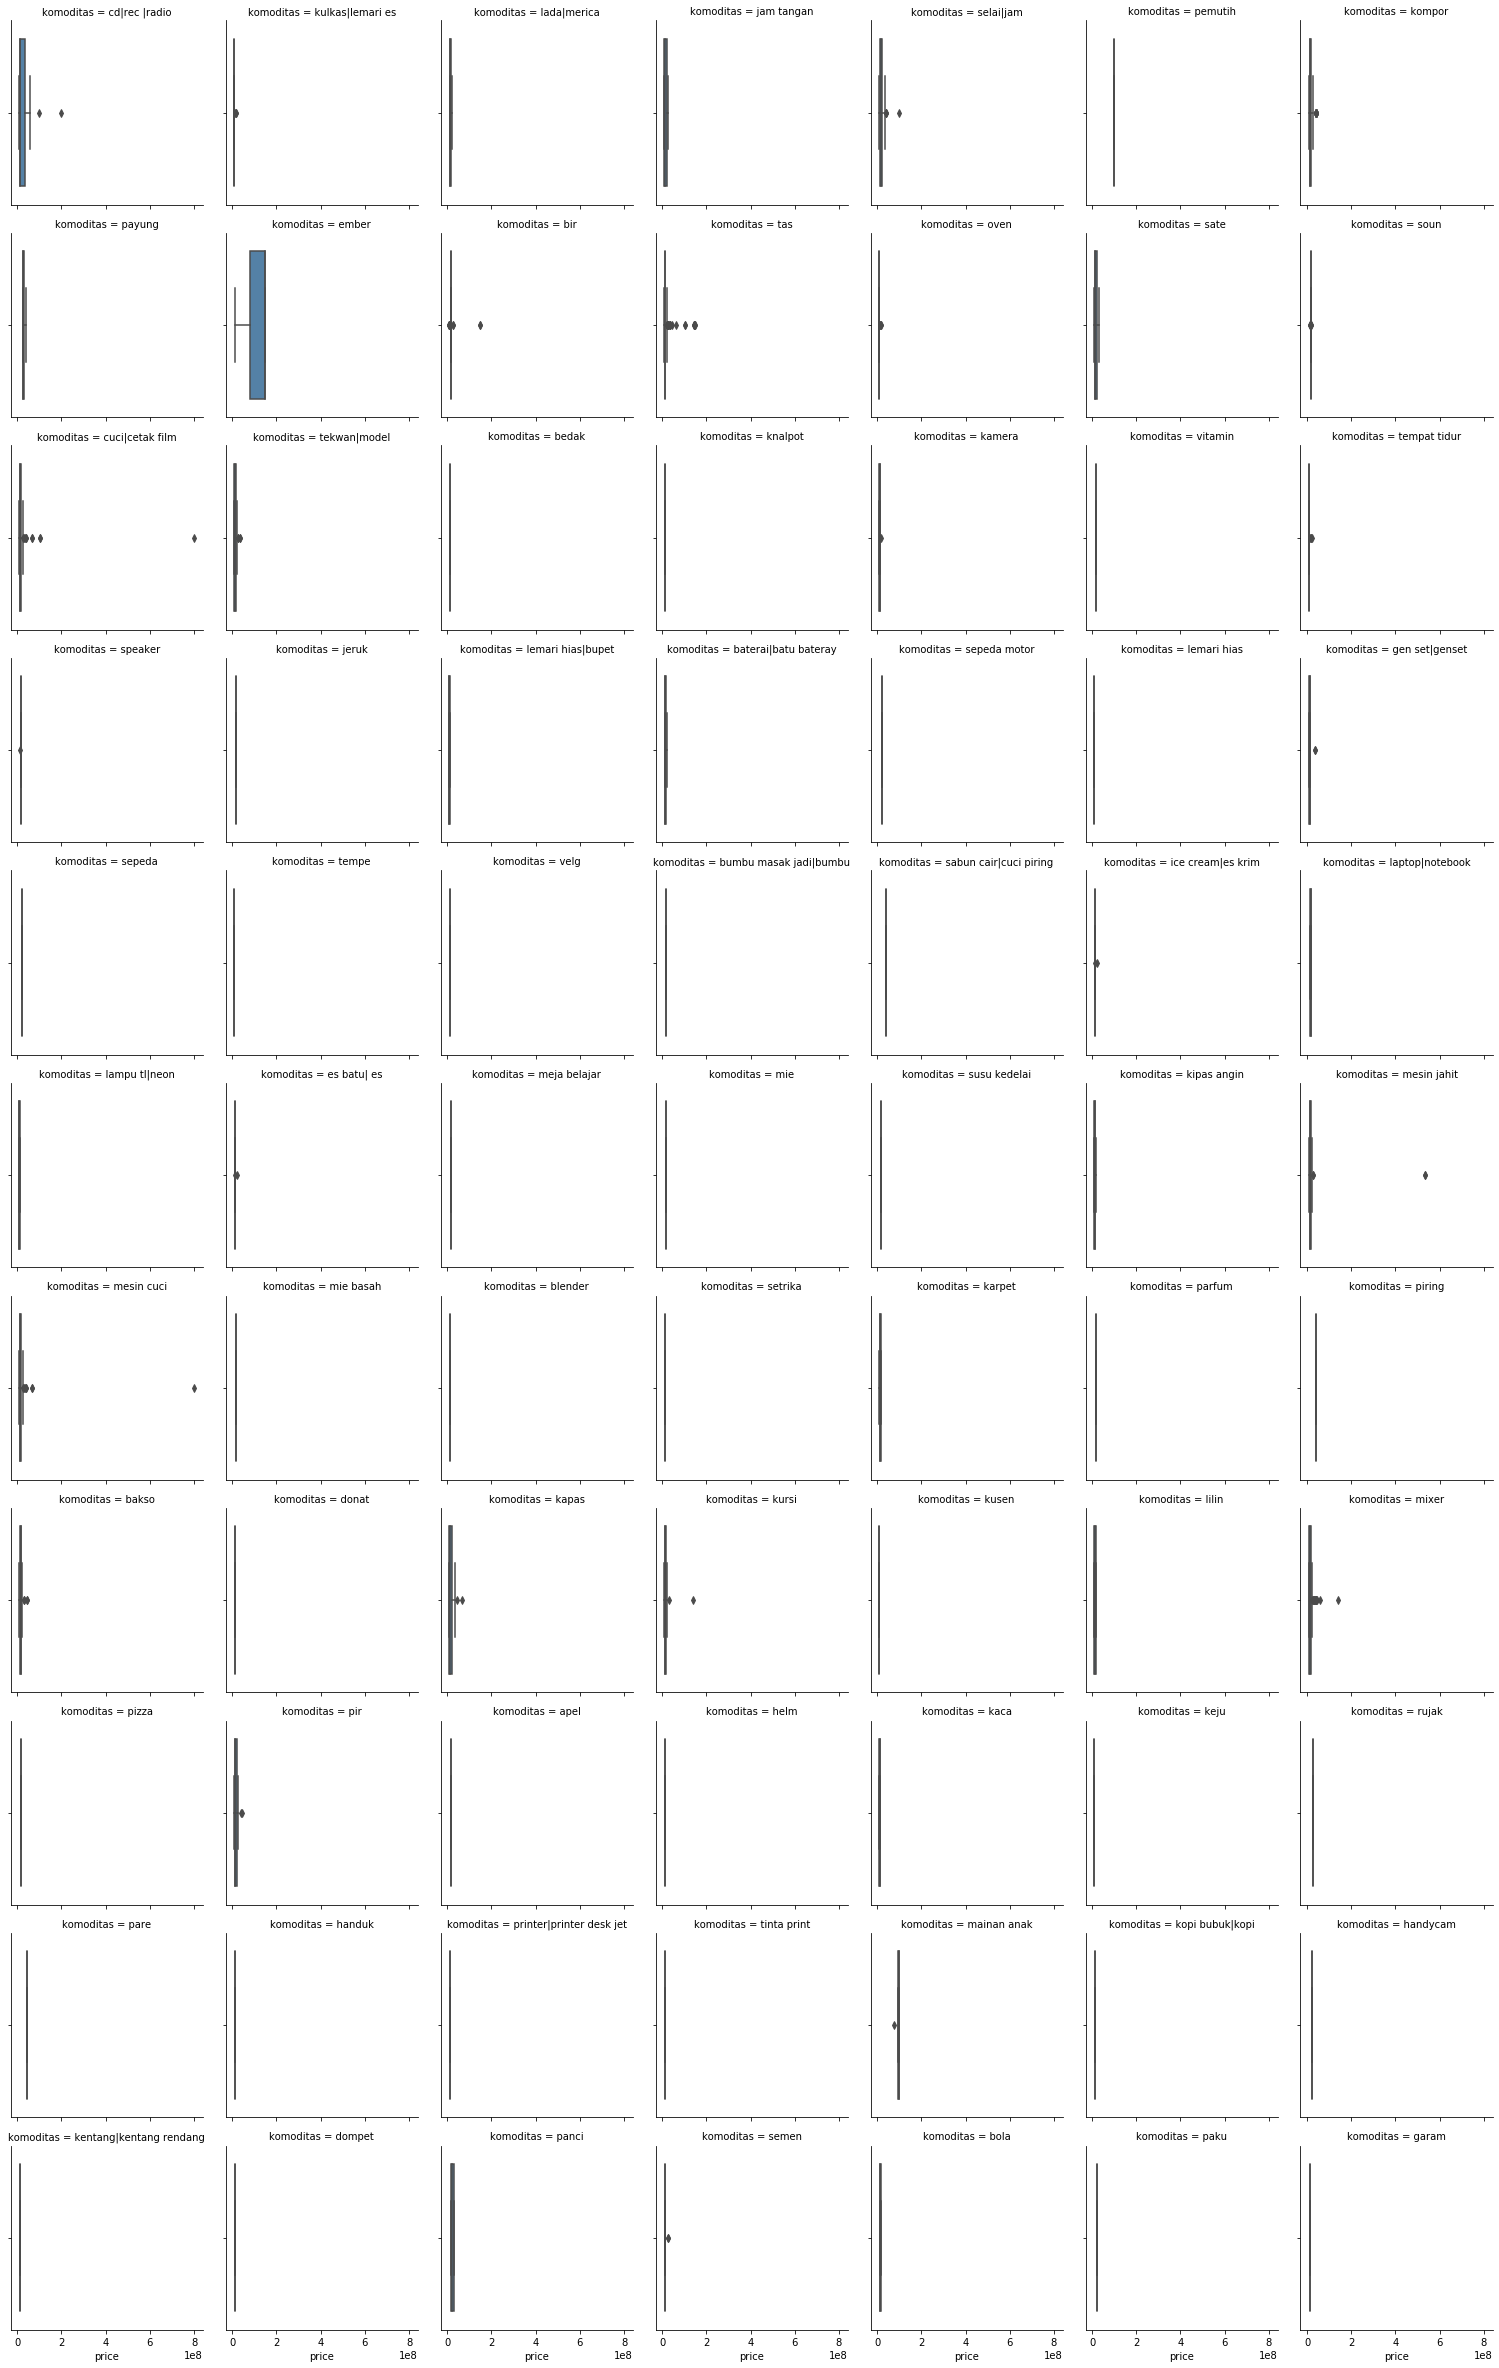

In [65]:
h = sns.FacetGrid(fraud_price_apr, col="komoditas", margin_titles=True, col_wrap=7)
sns_plot = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
sns_plot.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\fraud_price_apr.png")

In [402]:
fraud_price_apr_b = s_apr[s_apr['price'] <= 100]
fraud_price_apr_b.komoditas.nunique()

18

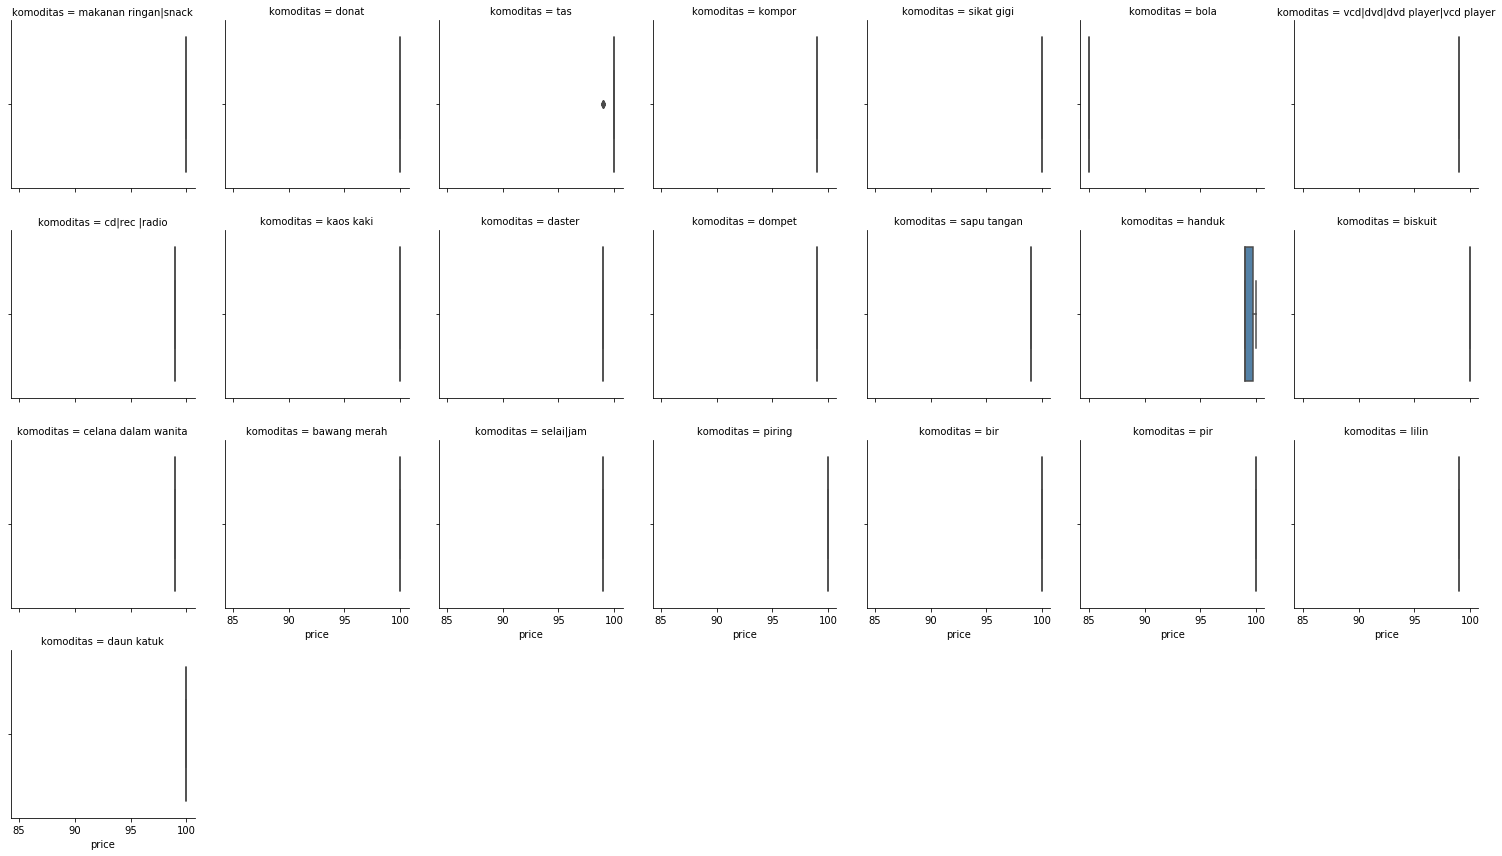

In [72]:
# h = sns.FacetGrid(fraud_price_apr_b, col="komoditas", margin_titles=True, col_wrap=7)
# sns_plot = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
# sns_plot.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\shopees\\output\\fraud_price_apr_b.png")

### Cleaning


In [403]:
fraud_atasa = s_apr.price >= 9999999
fraud_bawaha =  s_apr.price <= 999

In [404]:
apr_nofraud = s_apr[~(fraud_atasa|fraud_bawaha)]
print('fraud apr berjumlah ', s_apr.shape[0]-apr_nofraud.shape[0])

fraud apr berjumlah  6414


In [405]:
apr_nofraud.komoditas.nunique()

450

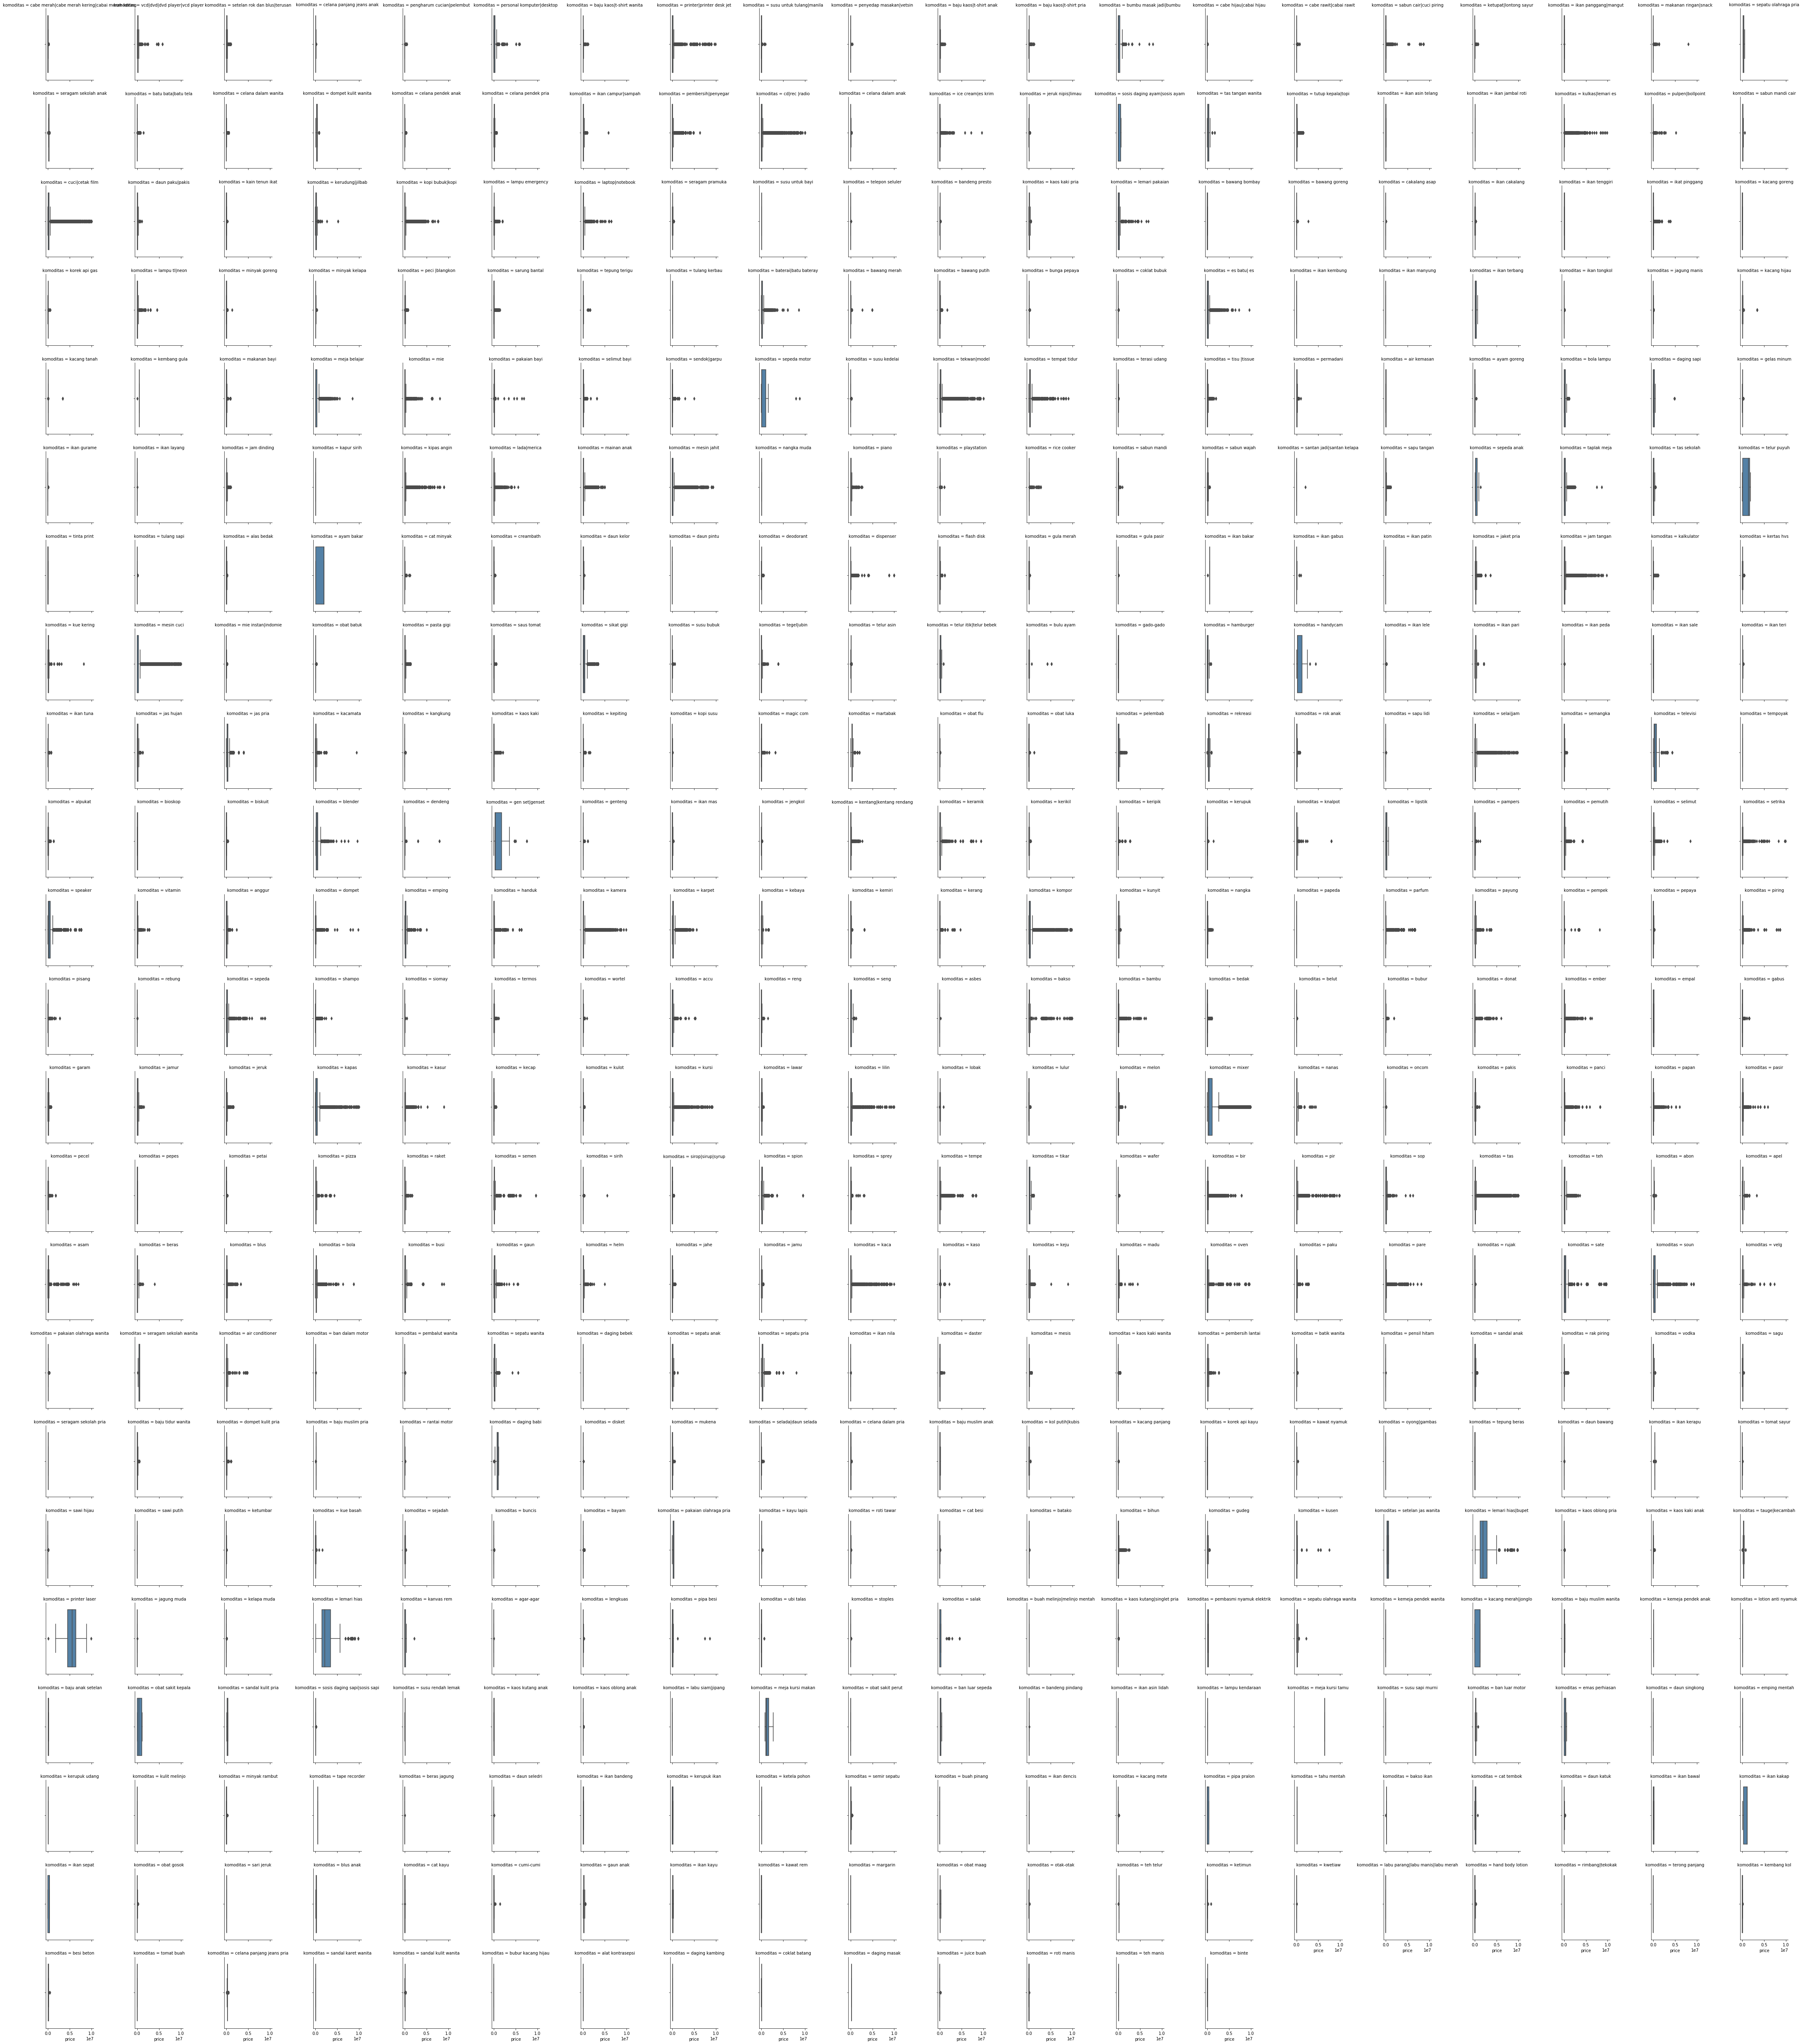

In [39]:
h = sns.FacetGrid(apr_nofraud, col="komoditas", margin_titles=True, col_wrap=20)
a = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
a.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\tanihub\\output\\nofraud_apr_boxplot.png")

In [17]:
fraud_atas = s_mei.price >= 9999999
fraud_bawah =  s_mei.price <= 999

In [18]:
mei_nofraud = s_mei[~(fraud_atas|fraud_bawah)]
print('fraud mei berjumlah ', s_mei.shape[0]-mei_nofraud.shape[0])

fraud mei berjumlah  39181


In [19]:
mei_nofraud.komoditas.nunique()

584

In [ ]:
me

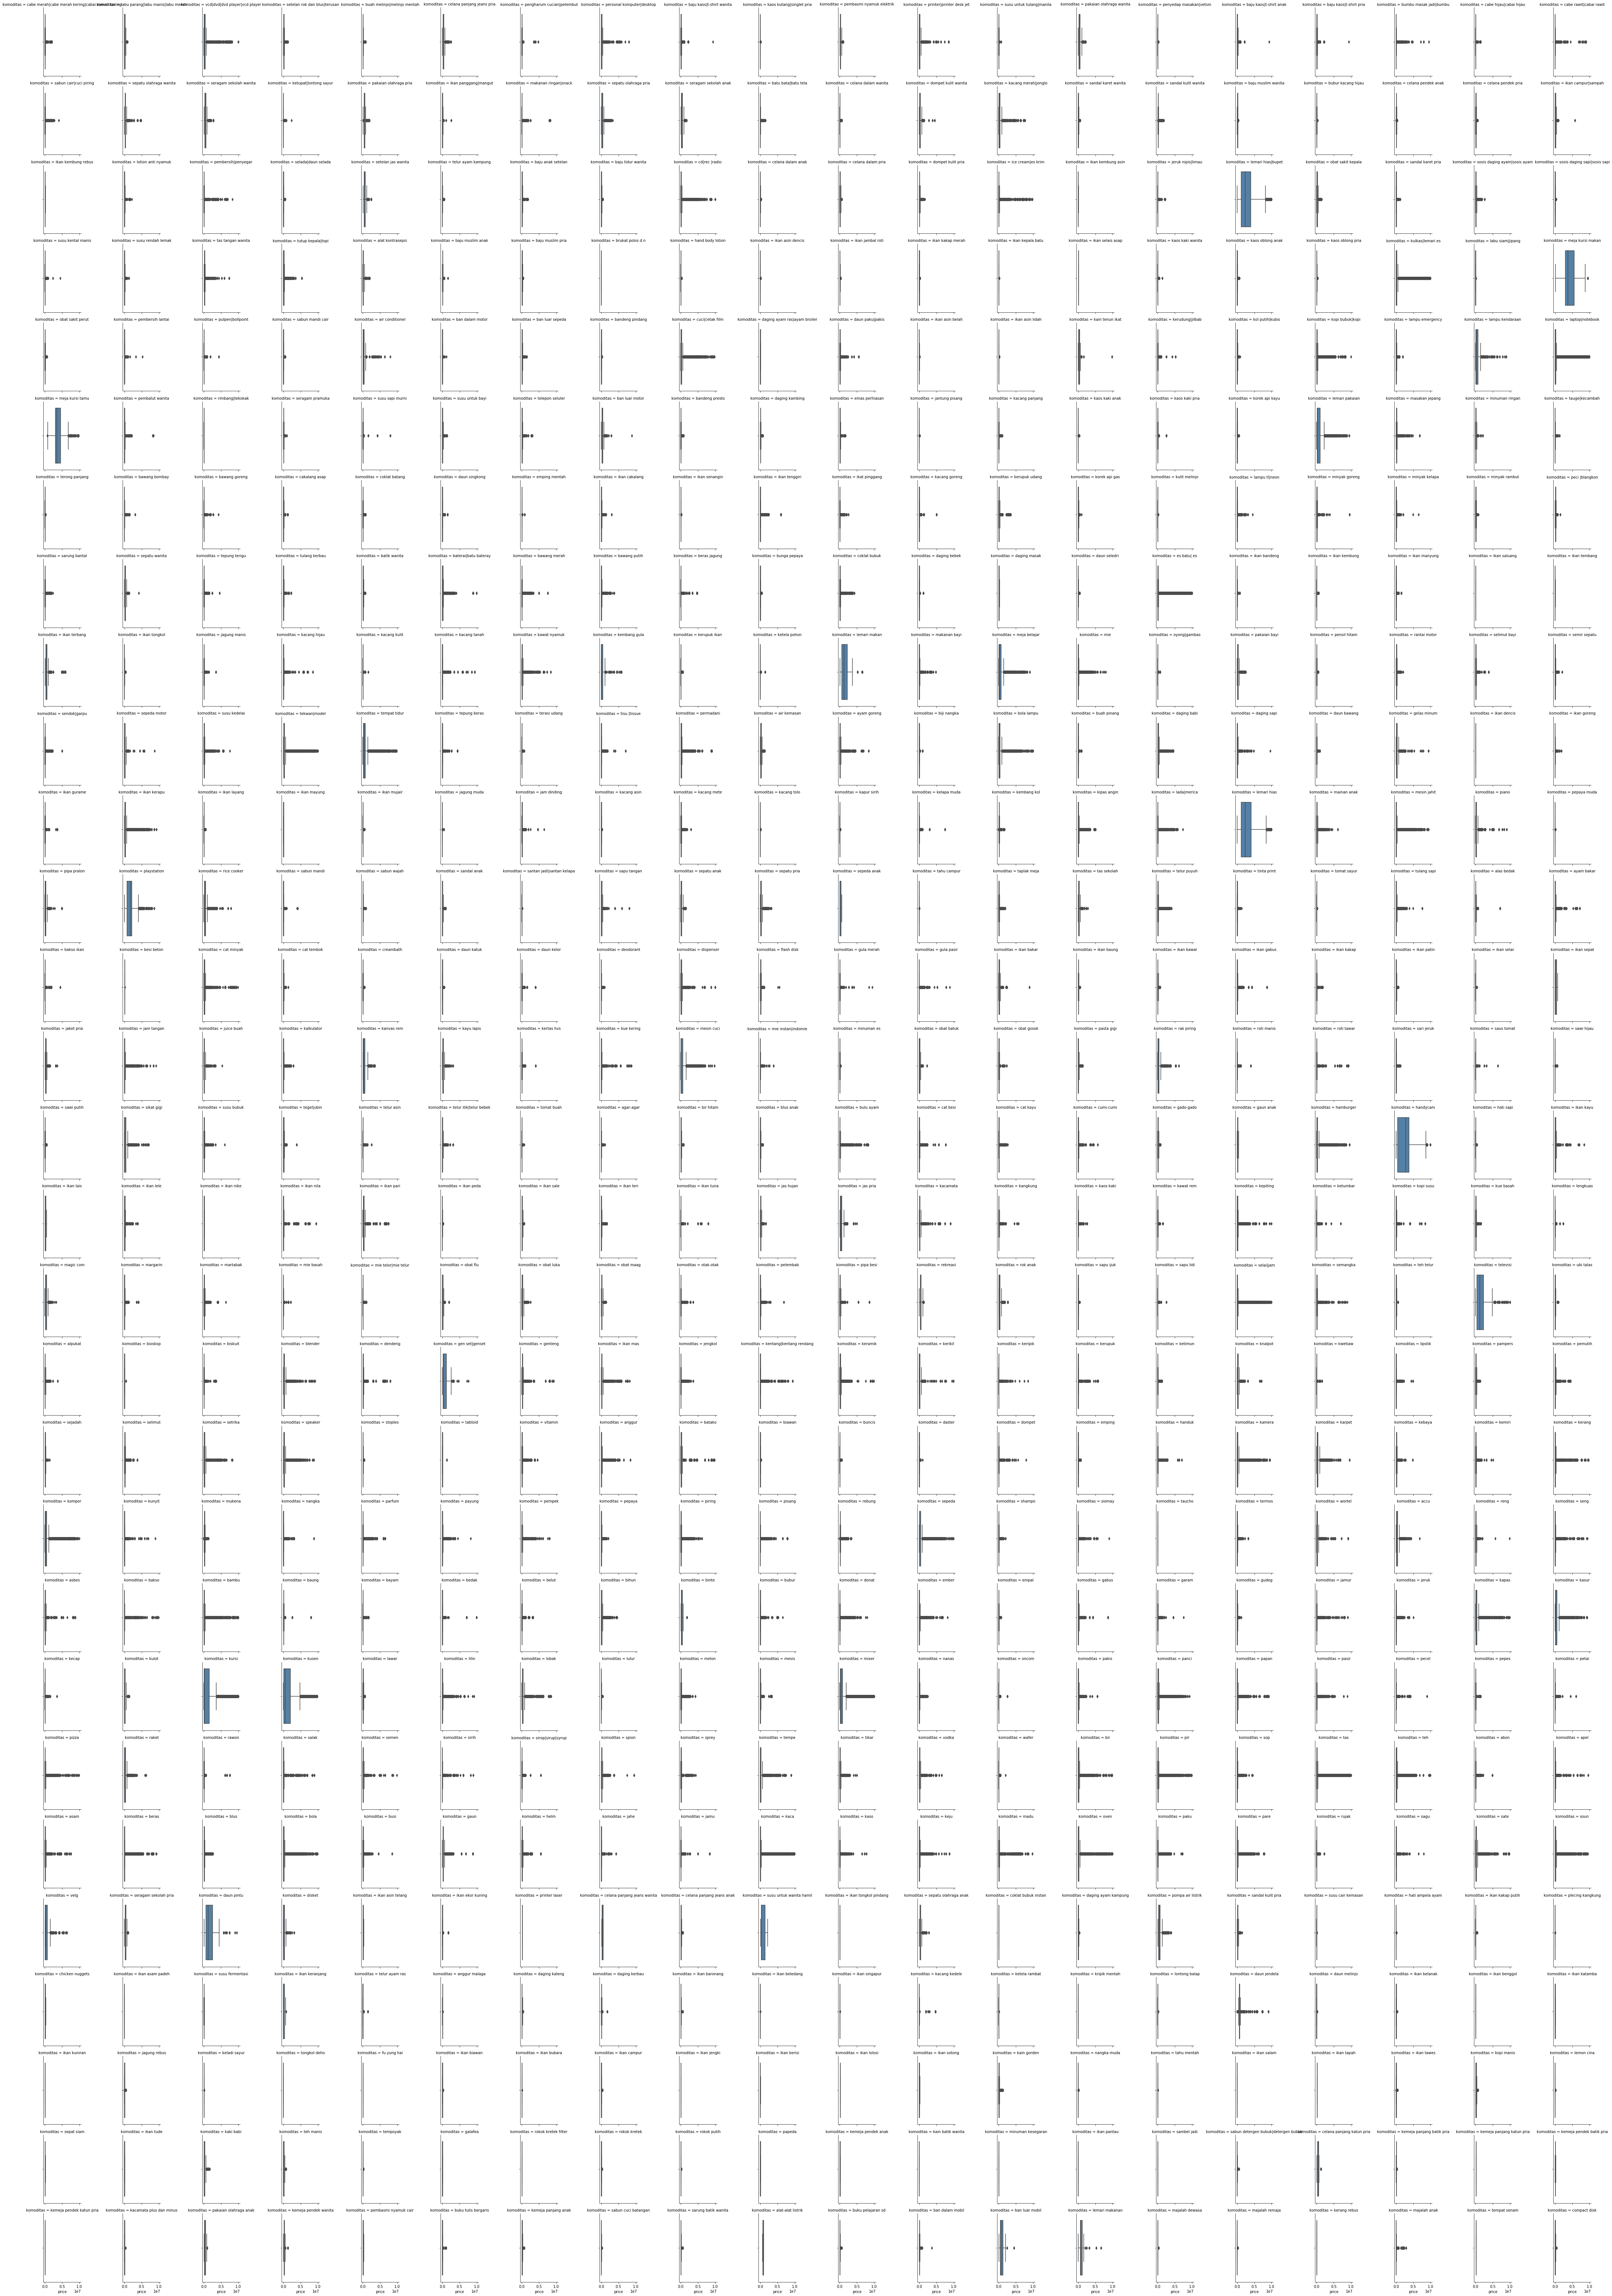

In [41]:
h = sns.FacetGrid(mei_nofraud, col="komoditas", margin_titles=True, col_wrap=20)
a = h.map(sns.boxplot, "price", color="steelblue", order="komoditas")
a.savefig("C:\\Users\\Ghozy Haqqoni\\Documents\\!Kuliah\\Semester_8_DS\\Training\\Scraping\\tanihub\\output\\nofraud_mei_boxplot.png")

In [20]:
vodka = mei_nofraud[mei_nofraud['komoditas'] == 'tempe']
vodka = vodka.reset_index(drop=True)
vodka[vodka['model_name']=='tempe']

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas
10582,1.624106e+09,11923005.0,Camilan kering kentang / tempe / teri cemilan ...,tempe,14551,Keripik & Kerupuk,26000.0,KOTA SURABAYA,84.0,50.0,129.0,2020-05-01,tempe
10585,1.624106e+09,11923005.0,Camilan kering kentang / tempe / teri cemilan ...,tempe,14551,Keripik & Kerupuk,26000.0,KOTA SURABAYA,84.0,50.0,129.0,2020-05-01,tempe
37434,1.983833e+09,16942283.0,Kering kentang Kering Tempe Teri Kacang (Made ...,tempe,14954,Menu Sarapan Lainnya,17500.0,KOTA MALANG,0.0,0.0,0.0,2020-05-14,tempe
38529,1.624106e+09,11923005.0,Camilan kering kentang / tempe / teri cemilan ...,tempe,14551,Keripik & Kerupuk,26000.0,KOTA SURABAYA,71.0,53.0,147.0,2020-05-14,tempe
39206,7.926445e+09,115294228.0,kk KOBE Tepung Goreng Tempe/kentucy [200/210g],tempe,14565,Tepung & Premix,5900.0,KOTA CIMAHI,9.0,3.0,9.0,2020-05-14,tempe
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145284,2.205867e+09,30346818.0,Tempe tahu bacem,tempe,12568,Makanan Beku Lainnya,13000.0,KOTA JAKARTA TIMUR,61.0,62.0,218.0,2020-05-20,tempe
148698,2.205867e+09,30346818.0,Tempe tahu bacem,tempe,12568,Makanan Beku Lainnya,13000.0,KOTA JAKARTA TIMUR,61.0,62.0,218.0,2020-05-20,tempe
149487,2.205867e+09,30346818.0,Tempe tahu bacem,tempe,12568,Makanan Beku Lainnya,13000.0,KOTA JAKARTA TIMUR,61.0,62.0,218.0,2020-05-20,tempe
153075,2.205867e+09,30346818.0,Tempe tahu bacem,tempe,12568,Makanan Beku Lainnya,13000.0,KOTA JAKARTA TIMUR,66.0,63.0,222.0,2020-05-22,tempe


In [151]:
berasan = ['beras']
mei_nofraud[mei_nofraud.komoditas.isin(berasan)]

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas
1255322,2.361970e+09,158155059.0,Bedak Dingin Berastagi Cap Astagina [Packing K...,Bedak Dingin,14880,Bedak,3500.0,KOTA SURABAYA,251.0,1448.0,1571.0,2020-05-01,beras
1255323,2.850109e+08,6049234.0,BEDAK DINGIN BERASTAGI cap ASTAGINA,NaN,14880,Bedak,20000.0,KOTA SURABAYA,73.0,NaN,5061.0,2020-05-01,beras
1255324,4.403084e+09,79757899.0,Beras merah murah beras merah 1kg pecah kulit ...,NaN,7514,Makanan & Vitamin Hewan,15000.0,KOTA DEPOK,18.0,NaN,174.0,2020-05-01,beras
1255325,4.020509e+09,45266323.0,Tempat beras 28kg Maspion EX2800,NaN,24638,Wadah Isi Ulang,320000.0,KOTA JAKARTA UTARA,2.0,NaN,3.0,2020-05-01,beras
1255326,6.525711e+09,125646432.0,Karung beras laminasi Lele Super 25kg,NaN,24638,Wadah Isi Ulang,3000.0,KOTA JAKARTA UTARA,150.0,NaN,150.0,2020-05-01,beras
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19191711,2.708519e+09,65733095.0,Jamu pencegahan Corona/Temulawak/B.Kunyit/k.as...,"Sirih+k.asem+pinang,1000ml/1ltr",7533,Minuman Nutrisi,65000.0,KOTA JAKARTA TIMUR,18.0,0.0,186.0,2020-05-29,beras
19191712,2.708519e+09,65733095.0,Jamu pencegahan Corona/Temulawak/B.Kunyit/k.as...,"Jahe,1000ml/1ltr",7533,Minuman Nutrisi,70000.0,KOTA JAKARTA TIMUR,18.0,1.0,186.0,2020-05-29,beras
19191713,2.708519e+09,65733095.0,Jamu pencegahan Corona/Temulawak/B.Kunyit/k.as...,"Jamu ANTI CORONA,1000ml/1ltr",7533,Minuman Nutrisi,70000.0,KOTA JAKARTA TIMUR,18.0,9.0,186.0,2020-05-29,beras
19191714,2.708519e+09,65733095.0,Jamu pencegahan Corona/Temulawak/B.Kunyit/k.as...,"B.kencur+jahe,1000ml/1ltr",7533,Minuman Nutrisi,60000.0,KOTA JAKARTA TIMUR,18.0,1.0,186.0,2020-05-29,beras


In [22]:
mei_nofraud.groupby(['sub_sub_name']).agg({'sub_sub_name' : ("count")})

,sub_sub_name
sub_sub_name,
Rak Gantung,3618
2-in-1,147
A Line Dress,19235
AC,784
Abaya,378
...,...
Work & Safety Boots,10008
Wraps,855
Wristband,333


In [23]:
mei_nofraud.groupby(['location','komoditas']).agg({'komoditas' : ("count")})

komoditas
location             komoditas                               
KAB. ACEH BARAT      minyak kelapa                          2
KAB. ACEH BARAT DAYA beras                                 13
                     dispenser                              2
                     kecap                                  1
                     mie                                    3
...                                                       ...
金門縣烈嶼鄉               kepiting                              69
                     tekwan|model                          71
高雄市三民區               lampu tl|lampu neon|lampu led          2
高雄市仁武區               hamburger                              5
高雄市岡山區               hamburger                              1

[45345 rows x 1 columns]

In [155]:
mei_nofraud.timestamp.sort_values(ascending=True).unique()

array(['2020-05-01T00:00:00.000000000', '2020-05-02T00:00:00.000000000',
       '2020-05-03T00:00:00.000000000', '2020-05-04T00:00:00.000000000',
       '2020-05-05T00:00:00.000000000', '2020-05-06T00:00:00.000000000',
       '2020-05-07T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-05-09T00:00:00.000000000', '2020-05-10T00:00:00.000000000',
       '2020-05-11T00:00:00.000000000', '2020-05-12T00:00:00.000000000',
       '2020-05-13T00:00:00.000000000', '2020-05-14T00:00:00.000000000',
       '2020-05-15T00:00:00.000000000', '2020-05-16T00:00:00.000000000',
       '2020-05-17T00:00:00.000000000', '2020-05-18T00:00:00.000000000',
       '2020-05-19T00:00:00.000000000', '2020-05-20T00:00:00.000000000',
       '2020-05-22T00:00:00.000000000', '2020-05-23T00:00:00.000000000',
       '2020-05-24T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
       '2020-05-26T00:00:00.000000000', '2020-05-27T00:00:00.000000000',
       '2020-05-29T00:00:00.000000000'], dtype='dat

In [24]:
range(len(vodka))

range(0, 200059)

In [25]:
vodka['location'].loc[0:,].apply(lambda x:0 if not x is string.printable else 1).value_counts()

0    200059
Name: location, dtype: int64

In [27]:
from fuzzywuzzy import fuzz
def get_ratio(row):
    name = row['sub_sub_name']
    name1 = row['komoditas']
    return fuzz.token_set_ratio(name, name1)
len(vodka[vodka.apply(get_ratio, axis=1) > 70]) / len(vodka)

C:\Users\Ghozy Haqqoni\Anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


0.002964125582953029

In [29]:
fuzz.token_set_ratio(vodka['sub_sub_name'], vodka['komoditas'])

90

In [30]:
fuzz.token_set_ratio('Wallpaper', 'tempe')

29

In [434]:
may = mei_nofraud.komoditas.unique().tolist()
pril = apr_nofraud.komoditas.unique().tolist()

In [444]:
mattch = list(set(may).intersection(pril))
len(mattch)

450

In [454]:
len(list(set(may) - set(pril)))

134

In [430]:
# [i for i, j in zip(mei_nofraud.komoditas.unique(), apr_nofraud.komoditas.unique()) if i == j]

In [31]:
df = mei_nofraud[mei_nofraud['komoditas'] == 'beras']
df = df.reset_index(drop=True)
df.model_name = df.model_name.astype(str)
df.sub_sub_name = df.sub_sub_name.astype(str)

In [32]:
df['name'] = df['name'].apply(lambda x: format(x.lower()))
df['model_name'] = df['model_name'].apply(lambda x: format(x.lower()))
df['sub_sub_name'] = df['sub_sub_name'].apply(lambda x: format(x.lower()))

In [406]:
dfa = apr_nofraud[apr_nofraud['komoditas'] == 'beras']
dfa = dfa.reset_index(drop=True)
dfa.model_name = dfa.model_name.astype(str)
dfa.sub_sub_name = dfa.sub_sub_name.astype(str)
dfa['name'] = dfa['name'].apply(lambda x: format(x.lower()))
dfa['model_name'] = dfa['model_name'].apply(lambda x: format(x.lower()))
dfa['sub_sub_name'] = dfa['sub_sub_name'].apply(lambda x: format(x.lower()))

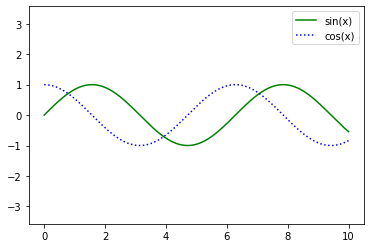

In [207]:
x  = np.linspace(0, 10, 1000)
plt.plot(x, np.sin(x), '-g', label='sin(x)')
plt.plot(x, np.cos(x), ':b', label='cos(x)')
plt.axis('equal')

plt.legend();

In [179]:
# from __future__ import division
# from pylab import plot, ylim, xlim, show, xlabel, ylabel, grid
# from numpy import linspace, loadtxt, ones, convolve

# def movingaverage(interval, window_size):
#     window = np.ones(window_size.astype(int))/float(window_size)
#     return np.convolve(interval, window, 'same')


In [370]:
df_b = df[(df['komoditas'] == 'beras') & (df['sub_sub_name'] == 'beras')]
df_b = df_b.reset_index(drop=True)
df_b['location'] = df_b['location'].str.replace(r'[^\x00-\x7F]+', 'Luar Negeri')
df_b = df_b[df_b['location'].notna()]

In [412]:
df_c = dfa[(dfa['komoditas'] == 'beras')]
df_c = df_c.reset_index(drop=True)
df_c['location'] = df_c['location'].str.replace(r'[^\x00-\x7F]+', 'Luar Negeri')
df_c = df_c[df_c['location'].notna()]

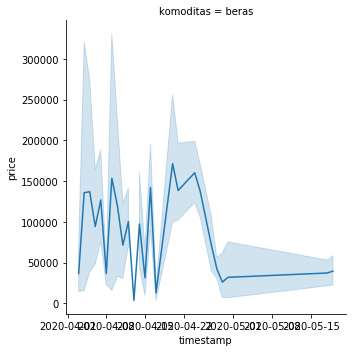

In [456]:
sns.relplot(x="timestamp", y="price",col="komoditas", kind="line", data=df_c)

In [371]:
df_b.timestamp.sort_values(ascending=True)

0       2020-05-14
6334    2020-05-14
6335    2020-05-14
6336    2020-05-14
6337    2020-05-14
           ...    
46339   2020-05-29
46340   2020-05-29
46341   2020-05-29
46335   2020-05-29
46430   2020-05-29
Name: timestamp, Length: 46431, dtype: datetime64[ns]

In [467]:
df_c.timestamp.unique()

array(['2020-04-03T00:00:00.000000000', '2020-04-04T00:00:00.000000000',
       '2020-04-05T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
       '2020-04-07T00:00:00.000000000', '2020-04-08T00:00:00.000000000',
       '2020-04-09T00:00:00.000000000', '2020-04-10T00:00:00.000000000',
       '2020-04-11T00:00:00.000000000', '2020-04-12T00:00:00.000000000',
       '2020-04-13T00:00:00.000000000', '2020-04-14T00:00:00.000000000',
       '2020-04-15T00:00:00.000000000', '2020-04-16T00:00:00.000000000',
       '2020-04-17T00:00:00.000000000', '2020-05-18T00:00:00.000000000',
       '2020-05-19T00:00:00.000000000', '2020-04-20T00:00:00.000000000',
       '2020-04-21T00:00:00.000000000', '2020-04-24T00:00:00.000000000',
       '2020-04-25T00:00:00.000000000', '2020-04-27T00:00:00.000000000',
       '2020-04-28T00:00:00.000000000', '2020-04-29T00:00:00.000000000',
       '2020-04-30T00:00:00.000000000'], dtype='datetime64[ns]')

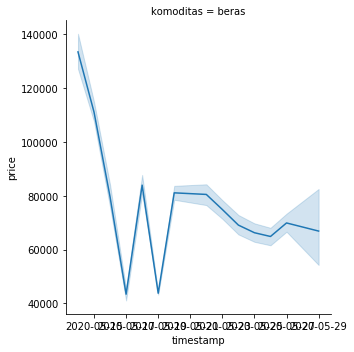

In [372]:
g = sns.relplot(x="timestamp", y="price",
                 col="komoditas", kind="line", data=df_b)

In [407]:
df_b.head(1)

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas
0,7.520517e+09,79535462.0,bisa cod / gojek / grab ! ] beras thailand jas...,nan,14571,beras,31500.0,KOTA TANGERANG,37.0,NaN,12507.0,2020-05-14,beras


In [540]:
df_b['price'][15]

225000.0

In [543]:
df_b.loc[15,]

item_id                                               1.57239e+09
shop_id                                                1.0881e+07
name            beras cap merek putri agri 20 kg pulen putih- ...
model_name                                                    nan
sub_sub_id                                                  14571
sub_sub_name                                                beras
price                                                      225000
location                                           KOTA TANGERANG
sold                                                            0
model_sold                                                    NaN
hist_sold                                                      33
timestamp                                     2020-05-14 00:00:00
komoditas                                                   beras
Name: 15, dtype: object

In [720]:
# del baru2
baru2 = _standardpricesBymodel(df_b)

In [721]:
baru2.price_perunit.sort_values(ascending=True)

12262        100.0
22459        100.0
26495        100.0
16292        231.0
1882         300.0
           ...    
5342     4110000.0
7984     4350000.0
7345     6750000.0
6938     7000000.0
8184     7150000.0
Name: price_perunit, Length: 46431, dtype: float64

In [722]:
#beras shirataki mahal
baru2[baru2.price_perunit > 10e+4].head(3)

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,price_perunit
186,4.429441e+09,84548478.0,beras shirataki / shirataki rice konnyaku 1 kg...,nan,14571,beras,239000.0,KOTA JAKARTA UTARA,56.0,NaN,104.0,2020-05-14,beras,239000.0
301,2.306424e+09,150670388.0,beras shirataki 1kg,nan,14571,beras,269900.0,KOTA BANDUNG,128.0,NaN,268.0,2020-05-14,beras,269900.0
402,3.802216e+09,62043505.0,beras shirataki repack 100 gr 50 gr / beras si...,100gr,14571,beras,27800.0,KOTA MALANG,74.0,383.0,442.0,2020-05-14,beras,278000.0


In [723]:
#remove "plastik" in df because it's not suitable with current list.
baru2 = baru2[~baru2.name.str.contains("plastik",na=False, flags=re.IGNORECASE)]
baru2 = baru2[~baru2.name.str.contains("jamu",na=False, flags=re.IGNORECASE)]
baru2 = baru2[~baru2.name.str.contains("premium",na=False, flags=re.IGNORECASE)]

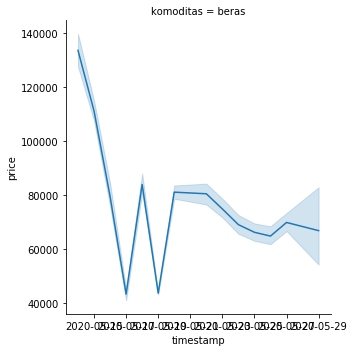

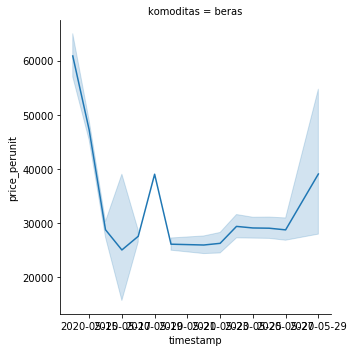

In [724]:
sns.relplot(x="timestamp", y="price",
                 col="komoditas", col_wrap=1,
                 kind="line", data=df_b)
sns.relplot(x="timestamp", y="price_perunit",
                 col="komoditas", col_wrap=1,
                 kind="line", data=baru2)

## Remove Outlier

In [725]:
Q1 = baru2.price_perunit.quantile(0.25)
Q3 = baru2.price_perunit.quantile(0.75)
IQR = Q3 - Q1
out_atas = baru2.price_perunit > (Q3 + 1.5 * IQR)
out_bawah =  baru2.price_perunit < (Q1 - 1.5 * IQR)
#outliernya
# df_b[(out_atas|out_bawah)]
df_clean = baru2[~(out_atas|out_bawah)]
print('outlier berjumlah ', df_b.shape[0]-df_clean.shape[0])

outlier berjumlah  4355


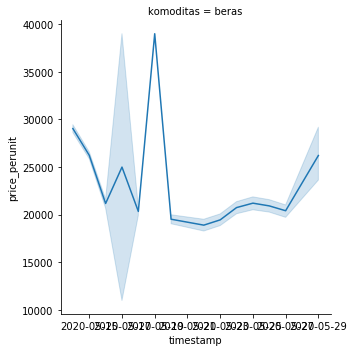

In [726]:
g = sns.relplot(x="timestamp", y="price_perunit",
                 col="komoditas", col_wrap=1,
                 kind="line", data=df_clean)

In [727]:
df_clean.price_perunit.sort_values(ascending=True) #04 - 21 mei

16292      231.0
1882       300.0
13579      300.0
17107      910.0
269        980.1
          ...   
3130     77000.0
23273    77000.0
25542    77000.0
15276    77000.0
7630     77000.0
Name: price_perunit, Length: 42076, dtype: float64

In [728]:
df_clean[df_clean['price_perunit']<1000].head()

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,price_perunit
269,2.245778e+09,148868598.0,beras setra ramos slyp super 5kg-50kg,5 liter,14571,beras,49005.0,KOTA JAKARTA TIMUR,1825.0,394.0,9245.0,2020-05-14,beras,980.1
1882,5.021109e+09,46966676.0,"beras broken 1kg, 5kg, 10kg, 25kg","putih,1kg",14571,beras,7500.0,KAB. GRESIK,5.0,6.0,6.0,2020-05-14,beras,300.0
9523,2.245778e+09,148868598.0,beras setra ramos slyp super 5kg-50kg,5 liter,14571,beras,49005.0,KOTA JAKARTA TIMUR,1748.0,397.0,9294.0,2020-05-15,beras,980.1
13579,5.021109e+09,46966676.0,"beras broken 1kg, 5kg, 10kg, 25kg","putih,1kg",14571,beras,7500.0,KAB. GRESIK,5.0,6.0,6.0,2020-05-15,beras,300.0
16292,5.832052e+09,243743603.0,beras super pulen slyp 10-50kg,nan,14571,beras,11550.0,KAB. CIREBON,0.0,NaN,0.0,2020-05-15,beras,231.0


In [729]:
df_clean.name[33530]

'beras setra ramos slyp super 5kg-50kg'

In [730]:
df_clean.loc[546,'price_perunit']

10000.0

In [742]:
df_clean[df_clean.price_perunit > 4e+4]

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,price_perunit
16,1.528215e+09,5293559.0,beras basmati / basmati rice / abukas - 1kg,nan,14571,beras,75000.0,KOTA JAKARTA BARAT,0.0,NaN,25.0,2020-05-14,beras,75000.0
17,1.378024e+09,10881003.0,beras organik sertifikat mentik susu- gosend,nan,14571,beras,52000.0,KOTA TANGERANG,0.0,NaN,29.0,2020-05-14,beras,52000.0
60,2.419138e+09,65323877.0,jatiluwih beras merah organik 1kg,nan,14571,beras,43000.0,KOTA JAKARTA UTARA,40.0,NaN,218.0,2020-05-14,beras,43000.0
90,4.111459e+09,97250227.0,beras zakat fitrah / beras sumbangan / beras s...,nan,14571,beras,43000.0,KOTA JAKARTA BARAT,10.0,NaN,11.0,2020-05-14,beras,43000.0
155,7.931918e+07,11347879.0,beras merah holistic- diabet,nan,14571,beras,67000.0,KOTA JAKARTA UTARA,3.0,NaN,51.0,2020-05-14,beras,67000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46389,3.147902e+09,73274806.0,fits beras analog rasa rawon,nan,14571,beras,45000.0,KOTA DENPASAR,0.0,NaN,0.0,2020-05-29,beras,45000.0
46400,4.333144e+09,226684785.0,beras cap nanas,nan,14571,beras,75000.0,KOTA BEKASI,0.0,NaN,0.0,2020-05-29,beras,75000.0
46405,7.332500e+09,29173416.0,beras kelapa muda,nan,14571,beras,58000.0,KOTA SURABAYA,0.0,NaN,0.0,2020-05-29,beras,58000.0
46406,1.824591e+09,83239941.0,beras kelapa muda,nan,14571,beras,57000.0,KOTA SURABAYA,0.0,NaN,0.0,2020-05-29,beras,57000.0


In [797]:
searchfor = ['basmati', 'pulen', 'super', 'organi', 'shirataki', 'premium',
             'tempat', 'kencur', 'jepang', 'garudafood', 'rantai', 'beras merah',
             'rojo', 'lumbung', 'sirup', 'plastik', 'infaq', 'zakat', 
             'spesial', 'japan', 'kebuli', 'karung', 'broken']
df_clean = df_clean[~df_clean.name.str.contains('|'.join(searchfor))]

In [787]:
df_clean.loc[546,'price_perunit']

10000.0

In [788]:
a = df_clean.groupby('timestamp')['price_perunit'].mean()
aa = pd.DataFrame(a)
aa.reset_index(level=0, inplace=True)
aa.columns

Index(['timestamp', 'price_perunit'], dtype='object')

In [789]:
aa

,timestamp,price_perunit
0,2020-05-14,22805.914089
1,2020-05-15,20409.906917
2,2020-05-16,18552.751557
3,2020-05-17,24997.500000
4,2020-05-18,17232.490662
5,2020-05-19,39000.000000
6,2020-05-20,18096.245852
7,2020-05-22,17086.885089
8,2020-05-23,17224.865328
9,2020-05-24,18578.841010


In [800]:
df_clean.shape

(13835, 14)

In [799]:
df_clean[df_clean.hist_sold == 0].shape

(4841, 14)

In [803]:
df_clean[df_clean.price_perunit > 6e+4].head()

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,price_perunit
370,2.457835e+09,35480723.0,beras sumo merah,"merah,5kg",14571,beras,64800.0,KOTA JAKARTA TIMUR,85.0,192.0,268.0,2020-05-14,beras,64800.0
735,5.508528e+09,143182522.0,beras nagano 1kg 3 pcack (harga + ongkir),nan,14571,beras,69500.0,KOTA JAKARTA UTARA,21.0,NaN,84.0,2020-05-14,beras,69500.0
917,6.699608e+08,36319884.0,beras khusus bmw pandan wangi asli 5 kg,pandan wangi bmw 20,14571,beras,320000.0,KOTA TANGERANG SELATAN,12.0,3.0,28.0,2020-05-14,beras,64000.0
951,7.931948e+07,11347879.0,beras putih holistic- diabet,nan,14571,beras,64700.0,KOTA JAKARTA UTARA,11.0,NaN,350.0,2020-05-14,beras,64700.0
1072,1.721578e+08,6702612.0,karak beras valentine,nan,14571,beras,67000.0,KOTA SURAKARTA (SOLO),7.0,NaN,27.0,2020-05-14,beras,67000.0


In [804]:
Q1 = df_clean.price_perunit.quantile(0.25)
Q3 = df_clean.price_perunit.quantile(0.75)
IQR = Q3 - Q1
out_atas = df_clean.price_perunit > (Q3 + 1.5 * IQR)
out_bawah =  df_clean.price_perunit < (Q1 - 1.5 * IQR)
#outliernya
# df_b[(out_atas|out_bawah)]
df_clean2 = df_clean[~(out_atas|out_bawah)]
print('outlier berjumlah ', df_clean.shape[0]-df_clean2.shape[0])

outlier berjumlah  1638


In [806]:
aseli = verf.drop(['item_id', 'shop_id', 'model_name', 'sub_sub_id', 'sub_sub_name', 'sold', 'model_sold', 'hist_sold'], axis =1)
aseli.to_csv(r"C:\Users\Ghozy Haqqoni\Documents\!Kuliah\Semester_7_DS\Skripsi\fix\penulisan\output\backup2ShopeeBerasMei.csv")

In [765]:
avgkomber = verf.price_perunit.mean()
avgkomber

19985.963317233334

In [762]:
verf.price_perunit.values

array([31500.,  5400., 10800., ..., 25000., 15000., 39000.])

## Make dummy data

In [ ]:
from faker import Factory
import random

faker = Factory.create()
status = 'created,delivered,returned'.split(',')

def date_between(d1, d2):
    f = '%b%d-%Y'
    return faker.date_time_between_dates(datetime.strptime(d1, f), datetime.strptime(d2, f))

def fakerecord():
    return {'awb': faker.numerify('######'),  # random number eg:235533
            'destination_city': faker.city(),  # random cities
            'product': 'random_product',  # different products
            'product_category': 'random_category',  # different categories
            'origin_city': faker.city(),  # random metro cities
            'logistics_provider_id': faker.numerify('##'),  # id's eg:1,20,28,27
            'dispatch_date': date_between('mar01-2015', 'mar15-2015'),  # datetime between mar01-2015 to mar15-2015
            'final_delivery_status': random.choice(status),  # created,delivered,returned
            'actual_delivery_date': date_between('mar16-2015', 'mar30-2015'),  # datetime between mar16-2015 to mar30-2015
            'promised_delivery_date': date_between('mar25-2015', 'apr06-2015'),  # datetime between mar25-2015 to Apr6-2015
            }

example_dummy_data = pandas.DataFrame([fakerecord() for _ in range(1000)])

## Daging ayam ras

In [774]:
df_ayam = mei_nofraud[mei_nofraud['komoditas'] == 'daging ayam ras|ayam broiler']
df_ayam = df_ayam.reset_index(drop=True)
df_ayam.model_name = df_ayam.model_name.astype(str)
df_ayam.sub_sub_name = df_ayam.sub_sub_name.astype(str)
df_ayam['location'] = df_ayam['location'].str.replace(r'[^\x00-\x7F]+', 'Luar Negeri')
df_ayam = df_ayam[df_ayam['location'].notna()]
df_ayam['name'] = df_ayam['name'].apply(lambda x: format(x.lower()))
df_ayam['model_name'] = df_ayam['model_name'].apply(lambda x: format(x.lower()))
df_ayam['sub_sub_name'] = df_ayam['sub_sub_name'].apply(lambda x: format(x.lower()))

In [775]:
ayam = _standardpricesBymodel(df_ayam)

In [778]:
ayam.price.sort_values(ascending=True)

34       1700.0
17       1700.0
67       4000.0
158      4000.0
226      4000.0
         ...   
247    110000.0
216    110000.0
52     110000.0
10     110000.0
258    110000.0
Name: price, Length: 300, dtype: float64

In [779]:
Q1 = ayam.price_perunit.quantile(0.25)
Q3 = ayam.price_perunit.quantile(0.75)
IQR = Q3 - Q1
out_atas = ayam.price_perunit > (Q3 + 1.5 * IQR)
out_bawah =  ayam.price_perunit < (Q1 - 1.5 * IQR)
#outliernya
# df_b[(out_atas|out_bawah)]
df_clean_ayam = ayam[~(out_atas|out_bawah)]
print('outlier berjumlah ', ayam.shape[0]-df_clean_ayam.shape[0])

outlier berjumlah  0


In [782]:
verff

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,price_perunit
0,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,manis,18879,makanan kering,46000.0,KAB. SUKOHARJO,1.0,0.0,8.0,2020-05-01,daging ayam ras|ayam broiler,46000.0
1,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,pedas,18879,makanan kering,47000.0,KAB. SUKOHARJO,1.0,0.0,8.0,2020-05-01,daging ayam ras|ayam broiler,47000.0
2,2.755960e+09,78001669.0,neobro 250 gr - vitamin penambah berat penggem...,nan,12666,obat hewan,32500.0,KAB. SIDOARJO,2.0,NaN,73.0,2020-05-04,daging ayam ras|ayam broiler,32500.0
3,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,manis,18879,makanan kering,46000.0,KAB. SUKOHARJO,2.0,0.0,9.0,2020-05-04,daging ayam ras|ayam broiler,46000.0
4,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,pedas,18879,makanan kering,47000.0,KAB. SUKOHARJO,2.0,0.0,9.0,2020-05-04,daging ayam ras|ayam broiler,47000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,pedas,18879,makanan kering,47000.0,KAB. SUKOHARJO,2.0,0.0,10.0,2020-05-29,daging ayam ras|ayam broiler,47000.0
296,2.209688e+09,36357354.0,empal susur daging ayam rasa recommended,"qtt,1",18448,makanan siap saji,4000.0,KAB. MALANG,0.0,0.0,7.0,2020-05-29,daging ayam ras|ayam broiler,4000.0
297,2.209688e+09,36357354.0,empal susur daging ayam rasa recommended,"qtt,3",18448,makanan siap saji,13000.0,KAB. MALANG,0.0,0.0,7.0,2020-05-29,daging ayam ras|ayam broiler,13000.0
298,2.209688e+09,36357354.0,empal susur daging ayam rasa recommended,"qtt,5",18448,makanan siap saji,21000.0,KAB. MALANG,0.0,0.0,7.0,2020-05-29,daging ayam ras|ayam broiler,21000.0


## Joints

In [807]:
df_ayam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 0 to 299
Data columns (total 13 columns):
item_id         300 non-null float64
shop_id         300 non-null float64
name            300 non-null object
model_name      300 non-null object
sub_sub_id      300 non-null object
sub_sub_name    300 non-null object
price           300 non-null float64
location        300 non-null object
sold            300 non-null float64
model_sold      193 non-null float64
hist_sold       300 non-null float64
timestamp       300 non-null datetime64[ns]
komoditas       300 non-null object
dtypes: datetime64[ns](1), float64(6), object(6)
memory usage: 32.8+ KB


In [808]:
df_ayam['merge_cat'] = df_ayam[['model_name', 'sub_sub_name']].progress_apply(lambda x: '|'.join(x), axis=1)
df_ayam.head()

,item_id,shop_id,name,model_name,sub_sub_id,sub_sub_name,price,location,sold,model_sold,hist_sold,timestamp,komoditas,merge_cat
0,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,manis,18879,makanan kering,46000.0,KAB. SUKOHARJO,1.0,0.0,8.0,2020-05-01,daging ayam ras|ayam broiler,manis|makanan kering
1,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,pedas,18879,makanan kering,47000.0,KAB. SUKOHARJO,1.0,0.0,8.0,2020-05-01,daging ayam ras|ayam broiler,pedas|makanan kering
2,2.755960e+09,78001669.0,neobro 250 gr - vitamin penambah berat penggem...,nan,12666,obat hewan,32500.0,KAB. SIDOARJO,2.0,NaN,73.0,2020-05-04,daging ayam ras|ayam broiler,nan|obat hewan
3,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,manis,18879,makanan kering,46000.0,KAB. SUKOHARJO,2.0,0.0,9.0,2020-05-04,daging ayam ras|ayam broiler,manis|makanan kering
4,2.718327e+09,23728837.0,abon mesran solo daging ayam rasa manis dan pedas,pedas,18879,makanan kering,47000.0,KAB. SUKOHARJO,2.0,0.0,9.0,2020-05-04,daging ayam ras|ayam broiler,pedas|makanan kering
